## DPP Final Project - Analysis

In [ ]:
import random 
import time
import networkx as nx
import matplotlib.pyplot as plt
from IPython.display import Image, display

from visualization import plot_graph, generate_degree_anonymization_gif, generate_betweenness_anonymization_gif, generate_closeness_anonymization_gif, plot_runtime_comparison
from utils import  check_isomorphic_classes
from experiments import positive_benchmark, negative_benchmark, run_metric_comparison_experiment
from metrics import compute_perquery_errors, compute_queryability_score, compute_global_loss
from social_anonymizer import SocialAnonymizer
from exceptions import AnonymizationImpossibleError

In [2]:
social_anonymizer = SocialAnonymizer()

Social networks are typically characterized by two main properties:
- **Property 1**: The vertex degree distribution follows a power law.
- **Property 2**:  The small-world phenomenon, characterized by short average path lengths and high clustering, is present.  

In the following analysis, we investigate two primary graph topologies using the proposed anonymization method: Erdős–Rényi (ER) graphs, commonly used as a baseline in graph analysis, and Barabási–Albert (BA) graphs, a simple model for generating synthetic networks that capture key structural properties of social networks.    

To simplify the implementation, the `SocialAnonymizer` class uses only edge addition as its anonymization strategy, without performing label generalization. 

### 1. Performance

#### 1.1. Isomoprhism check

In the paper, the Minimum DFS Code (M-DFS) is adopted to recognize and match isomorphic components when analyzing the neighborhood of a pair of nodes. However, the computational complexity of generating the exact Minimum DFS Code is factorial O(N!) in the worst case. This worst-case scenario occurs in a clique (i.e., a complete graph). Starting from the first node, there are N−1 choices for the next step; at the second node, there are N−2 choices, and so on. This results in (N−1)! different DFS traces to compare. While the search can be pruned by comparing the current trace with the best one found so far (discarding it if it is lexicographically larger), the exact calculation remains computationally prohibitive.  For this reason, while the code for producing the exact M-DFS is provided, it is not used in the `SocialAnonymizer` class.

Heuristics limiting the search space for determining the minimum DFS code can be used. However, by definition, heuristics may not spot the actual minimum code and yield a non-minimum code for graphs. As a consequence, they can produce false negatives (i.e., isomorphic graphs not recognized as such) or/and false positives (i.e., non-isomorphic graphs recognized as such). False positives are a threat to privacy because in the algorithm perfect component matches are not further manipulated to reach isomoprhism since they are considered already isomoprhic. Hence, the occurrence of false positives may leave in the final anonymized graph some nodes whose neighborhood is unique. Therefore, neighborhood attacks can be performed on those nodes. On the other hand, false negatives are not a problem, because, if the components are matched correctly by `most_similar_component` and the mapping satisfying isomoprhism is found, then `make_components_isomorphic` will apply no changes to the components, maintaining isomoprhism. However, if the false negatives are not paired correctly by `most_similar_component` or a wrong mapping is used, the algorithm leads to overanonymization (i.e., adding edges or generalizing label when not strictly necessary, causing an unnecessary information loss). Hence, heuristics admitting only false negatives can be adopted to speed up the process at the cost of utility. 

The NetworkX library provides the `is_isomorphic` method, which implements the VF2 algorithm described by L. P. Cordella et al. (2001). Like M-DFS, the algorithm is exact—producing neither false positives nor false negatives—and exhibits factorial worst-case complexity. However, on average, VF2 is considerably faster than a custom Python implementation of M-DFS-based isomoprhism check. This difference stems from the fact that VF2 operates directly on a pair of graphs by incrementally constructing and pruning a node-to-node mapping between them, allowing early termination when inconsistencies are detected. In contrast, M-DFS processes each graph independently by generating its canonical Minimum DFS code, pruning the search space of DFS encodings for a single graph, and only compares the resulting codes after their full computation. For this reason, VF2 was adopted in this project to replace M-DFS for isomorphism checks.

In [7]:
# Configuration
sizes = [5, 10, 15, 20]
p = 0.2

In [8]:
pos_MDFS_times, pos_vf2_times = positive_benchmark(sizes, p, trials=5, num_repetition=10, rng_seed=42)

Graph size: 100%|██████████| 4/4 [00:08<00:00,  2.08s/it]


In [10]:
neg_MDFS_times, neg_vf2_times = negative_benchmark(sizes, p, trials=5, num_repetition=10, rng_seed=42)

Graph size: 100%|██████████| 4/4 [01:19<00:00, 19.88s/it]


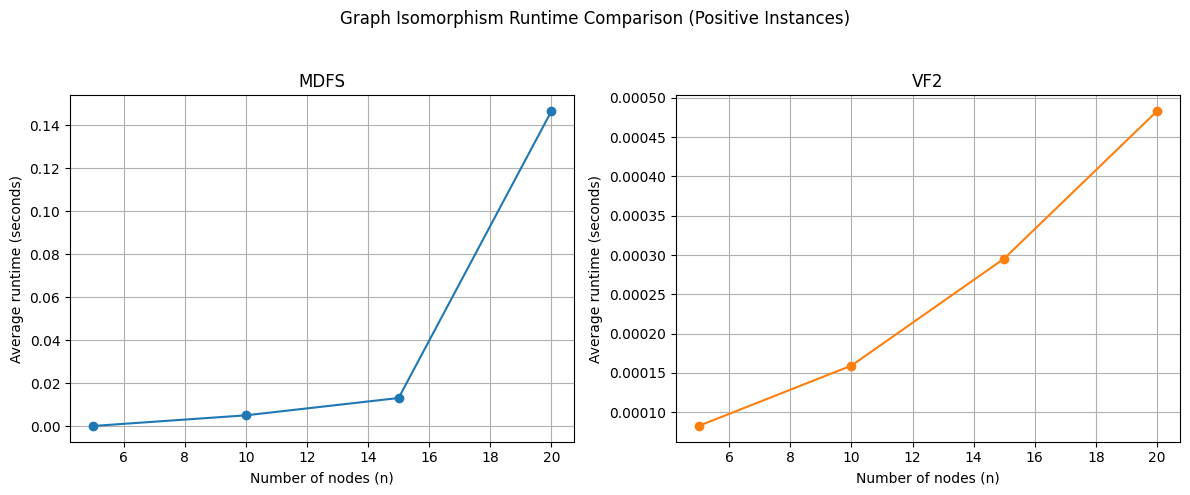

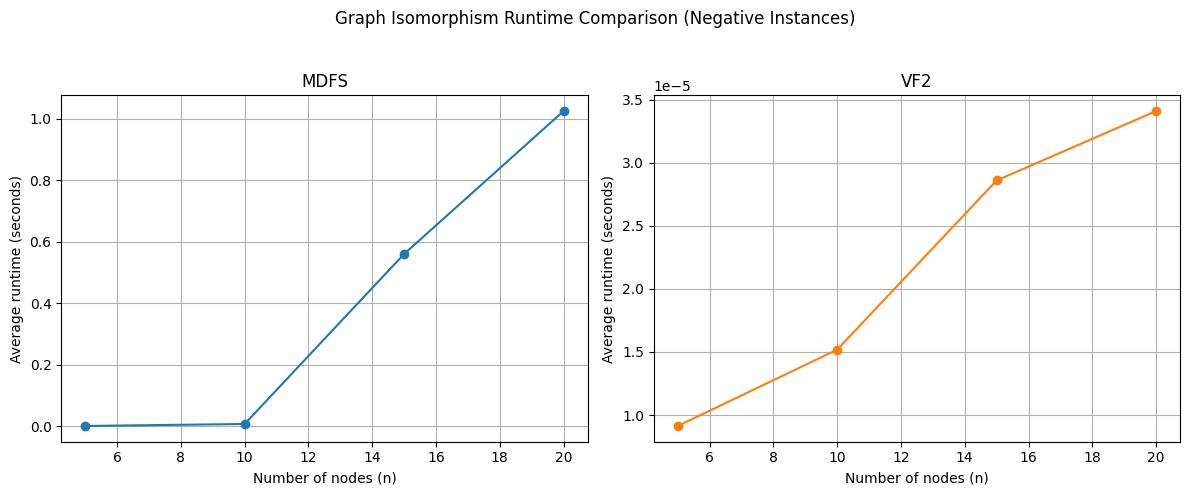

In [11]:
plot_runtime_comparison(sizes, pos_MDFS_times, pos_vf2_times,
    label_a='MDFS', label_b='VF2',
    suptitle='Graph Isomorphism Runtime Comparison (Positive Instances)')

plot_runtime_comparison(sizes, neg_MDFS_times, neg_vf2_times,
    label_a='MDFS', label_b='VF2',
    suptitle='Graph Isomorphism Runtime Comparison (Negative Instances)')

When detecting positive instances, the average runtime for both algorithms is monotonic with respect to the number of nodes. However, for negative instances, the NetworkX implementation of VF2 average runtime is not guaranteed to be monotonic.   

The reason for this difference lies in how the algorithms terminate. For `GraphMatcher.is_isomorphic()` to confirm two graphs are isomorphic (positive), it searches until it finds the first valid mapping; as graph size increases, finding this mapping generally takes longer, leading to monotonic growth. For negative instances, its performance is highly dependent on the specific input. If the graphs have different structural invariants (e.g, number of nodes and degree distribution), it detects the difference and rejects the pair almost instantly, regardless of graph size. However, if the graphs are structurally similar but not isomorphic, it must explore the search space more deeply to prove no mapping exists. This variability causes the non-monotonic behavior observed in negative instances.   

In contrast, the custom isomorphism check operates on each graph independently by computing its exact Minimum DFS (MDFS) code. The code generation procedure explores and prunes the search space of possible DFS encodings for a single graph, without considering any counterpart graph. Only after the canonical codes for both graphs have been fully computed are they compared to determine isomorphism. As a consequence, the runtime of this approach depends solely on the size and structural complexity of the individual input graphs, leading to a monotonic runtime trend for both positive and negative instances.

As expected, the NetworkX implementation of VF2 algorithm performs significantly better than the custom MDFS implementation, with a difference of three to four orders of magnitude in average runtime on toy instances.


#### 1.2. Algorithm time complexity

The paper does not provide a formal time complexity analysis for the anonymization algorithm. However, since the only two operations used to manipulate the graph are edge addition and label generalization, the algorithm is guaranteed to terminate for a finite social network of at least k vertices, as stated in Theorem 4. Indeed, in the worst-case scenario, the network is anonymized to a clique.   

Despite the termination guarantee, the time complexity of the `anonymize_graph` function is quite high, primarily due to subgraph isomorphism checks and the restart mechanisms triggered by topology changes in the neighborhoods.     
We can identify several costly operations performed by the algorithm:
- Vertex list sorting.
- Candidate selection.
- Group stabilization, where the loop is bounded by the maximum number of edges that can be added to the group's neighborhood.
- The `anonymize_pair` method, which serves as the main bottleneck due to:
    - Component extraction (identifying connected components in the subgraph induced by neighbors).
    - Isomorphism checks.
    - Greedy component matching (picking the largest component and finding the partner with the smallest anonymization cost).
    - The restart loop triggered if components merge.    

A dominant factor is the isomorphism check. Although the VF2 algorithm (used via NetworkX) is generally faster than MDFS, both make the algorithm scale poorly with the **number of nodes**.
In the case of VF2, a larger number of nodes N increases the depth of the recursion tree, corresponding to the number of node pairs that must be successfully mapped. 
Similarly, for MDFS, the computational complexity stems from the exhaustive exploration required to compute the canonical DFS code. Here, a larger N increases the depth of the DFS recursion. 
Consequently, whether using MDFS, which explores the space of possible DFS traversals, or VF2, which explores the space of candidate node mappings, applying `anonymize_graph` to large graphs leads to prohibitively slow execution times. The algorithm performs best on small graphs.   

Therefore, in its current implementation, the algorithm is **not** feasible for large-scale networks.

In [12]:
# section global configuration
k_values = [2, 3, 4]
num_of_repetition = 5
initial_seed = 42 
alpha = 0
beta = 1
gamma = 1
num_seeds = 5
graph_sizes = [10, 20, 30, 40, 50]
# fix average degree to spot only the effect of the number of nodes
fixed_avg_degree = 6

##### 1.2.1 Erdős–Rényi model

[Failure] size=10, k=3, seed=18289 failed (Result is not isomorphic). Discarding this seed and picking a new one.


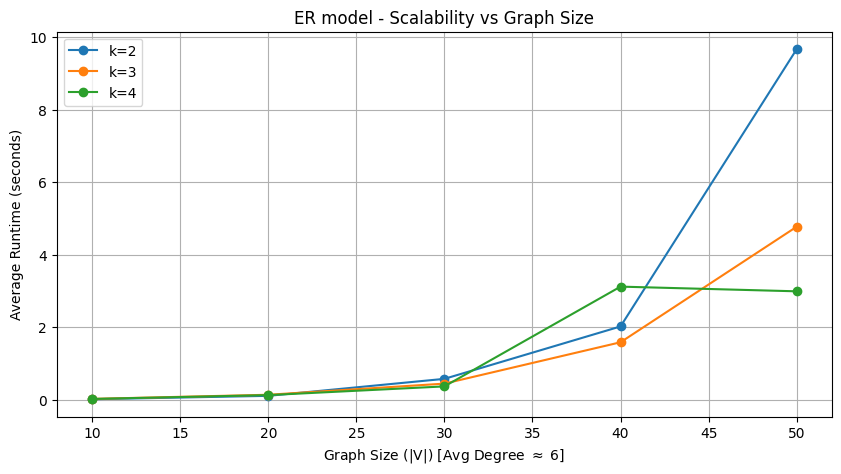

In [13]:
# loop over graph sizes
    # loop over k values
        # loop over seeds
            # loop over repetitions

results_size = {k: [] for k in k_values}
local_rng = random.Random(initial_seed)

for size in graph_sizes:
    if size <= 1:
        continue

    p = fixed_avg_degree / (size - 1)
    p = min(p, 1.0)

    for k in k_values:

        all_durations = []
        seed_count = 0

        while seed_count < num_seeds:

            # Generate graph for this seed
            current_seed = local_rng.randint(0, 100_000) # large to avoid collisions
            G_random = nx.gnp_random_graph(n=size, p=p, seed=current_seed)

            temp_durations = []
            seed_failed = False

            for _ in range(num_of_repetition):
                try:
                    start = time.time()

                    G_anon, eq_classes = social_anonymizer.anonymize_graph(G_random, k=k, alpha=alpha, beta=beta, gamma=gamma)

                    end = time.time()

                    # Validity check
                    if len(check_isomorphic_classes(G_anon, eq_classes)) != 0:
                        raise Exception("Result is not isomorphic")

                    temp_durations.append(end - start)

                except (AnonymizationImpossibleError, Exception) as e:
                    print(f"[Failure] size={size}, k={k}, seed={current_seed} failed ({e}). Discarding this seed and picking a new one.")
                    seed_failed = True
                    break

            if seed_failed:
                continue 
            else:
                all_durations.extend(temp_durations)
                seed_count += 1

        # average over all successful seeds × repetitions
        avg_duration = sum(all_durations) / len(all_durations)
        results_size[k].append((size, avg_duration))

# Plotting
plt.figure(figsize=(10, 5))
for k, data in results_size.items():
    if not data: continue
    x = [val[0] for val in data]
    y = [val[1] for val in data]
    plt.plot(x, y, marker='o', label=f"k={k}")

plt.xlabel(f"Graph Size (|V|) [Avg Degree $\\approx$ {fixed_avg_degree}]")
plt.ylabel("Average Runtime (seconds)")
plt.title("ER model - Scalability vs Graph Size")
plt.legend()
plt.grid(True)
plt.show()


##### 1.2.2 Barabási–Albert model

[Failure] size=10, k=2, seed=3278 failed (Result is not isomorphic). Discarding this seed and picking a new one.


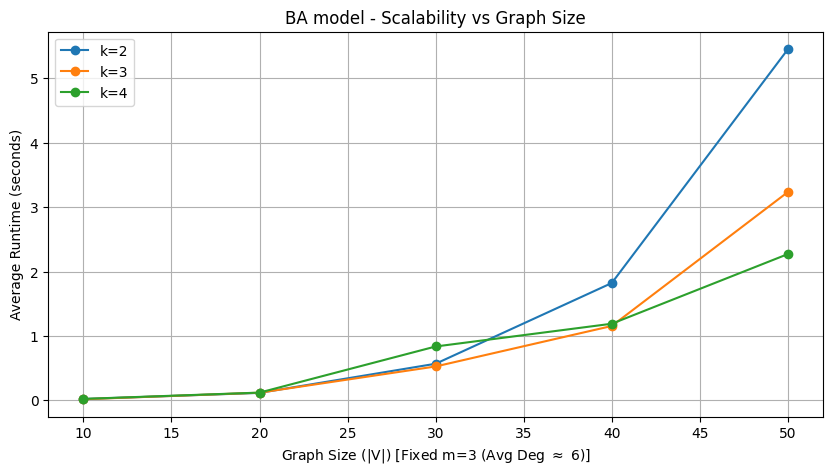

In [14]:
results_size = {k: [] for k in k_values}
fixed_m = int(fixed_avg_degree / 2)
local_rng = random.Random(initial_seed)

for size in graph_sizes:
    if size <= fixed_m:
        continue

    for k in k_values:

        all_durations = []

        seed_count = 0

        while seed_count < num_seeds:

             # Generate graph for this seed
            current_seed = local_rng.randint(0, 100_000)
            G_ba = nx.barabasi_albert_graph(n=size, m=fixed_m, seed=current_seed)

            temp_durations = []
            seed_failed = False

            for _ in range(num_of_repetition):
                try:
                    start = time.time()

                    G_anon, eq_classes = social_anonymizer.anonymize_graph(G_ba, k=k, alpha=alpha, beta=beta, gamma=gamma)

                    end = time.time()

                    if len(check_isomorphic_classes(G_anon, eq_classes)) != 0:
                        raise Exception("Result is not isomorphic")

                    temp_durations.append(end - start)

                except (AnonymizationImpossibleError, Exception) as e:
                    print(f"[Failure] size={size}, k={k}, seed={current_seed} failed ({e}). Discarding this seed and picking a new one.")
                    seed_failed = True
                    break

            if seed_failed:
                continue
            else:
                all_durations.extend(temp_durations)
                seed_count += 1

        avg_duration = sum(all_durations) / len(all_durations)
        results_size[k].append((size, avg_duration))

plt.figure(figsize=(10, 5))
for k, data in results_size.items():
    if not data: continue
    x = [val[0] for val in data]
    y = [val[1] for val in data]
    plt.plot(x, y, marker='o', label=f"k={k}")

plt.xlabel(f"Graph Size (|V|) [Fixed m={fixed_m} (Avg Deg $\\approx$ {fixed_avg_degree})]")
plt.ylabel("Average Runtime (seconds)")
plt.title("BA model - Scalability vs Graph Size")
plt.legend()
plt.grid(True)
plt.show()

### 2. Graph Metrics

When dealing with graphs, a significant amount of information is encoded in **graph metrics**.   
Since we are interested in social networks, node popularity (captured by degree centrality) is a particularly relevant metric. We will evaluate this alongside betweenness centrality, closeness centrality, and reachability. We define reachability as the number of connected components in the graph.     
The paper employs two methods to anonymize vertex neighborhoods: generalizing vertex labels and adding edges. Since the five metrics listed above are purely structural and do not account for node labels, they will change after anonymization only due to edge modification. Consequently, the information loss regarding these graph metrics is caused solely by edge addition.    

The goal of neighborhood isomorphism is to make nodes neighborhood indistinguishable **locally** (i.e., 1-neighborhood isomorphism) to prevent neighborhood attacks.     
Consequently:
- Local structure attacks are effectively prevented (e.g., those based on degree centrality or local clustering coefficient), as these metrics become identical for all nodes in an equivalence class.
- Global structure attacks remain a potential threat (e.g., those based on betweenness or closeness centrality), as local isomorphism does not hide fully a node's position within the overall network topology.

#### 2.1 Degree centrality

The degree distribution, a power law in social networks, will tend to flatten. As the graph approaches a clique structure, the distribution will collapse to a single value, ∣V∣−1, shared by all nodes. The closer k is to the total number of nodes, the more evident this flattening effect becomes. When k=∣V∣, every node will possess the exact same degree; as previously mentioned, this value will be ∣V∣−1 if the graph is anonymized into a clique, or a lower value if a regular isomorphic pattern with fewer edges is achieved.     
For random graphs, which serve as a baseline, the distribution is compressed from an initial Binomial distribution (often approximated by a Poisson distribution in large sparse graphs) to a single shared value as k increases toward k=∣V∣.

GIF saved to degree_frames_ER_n20_p0.05_seed25\degree_evolution.gif


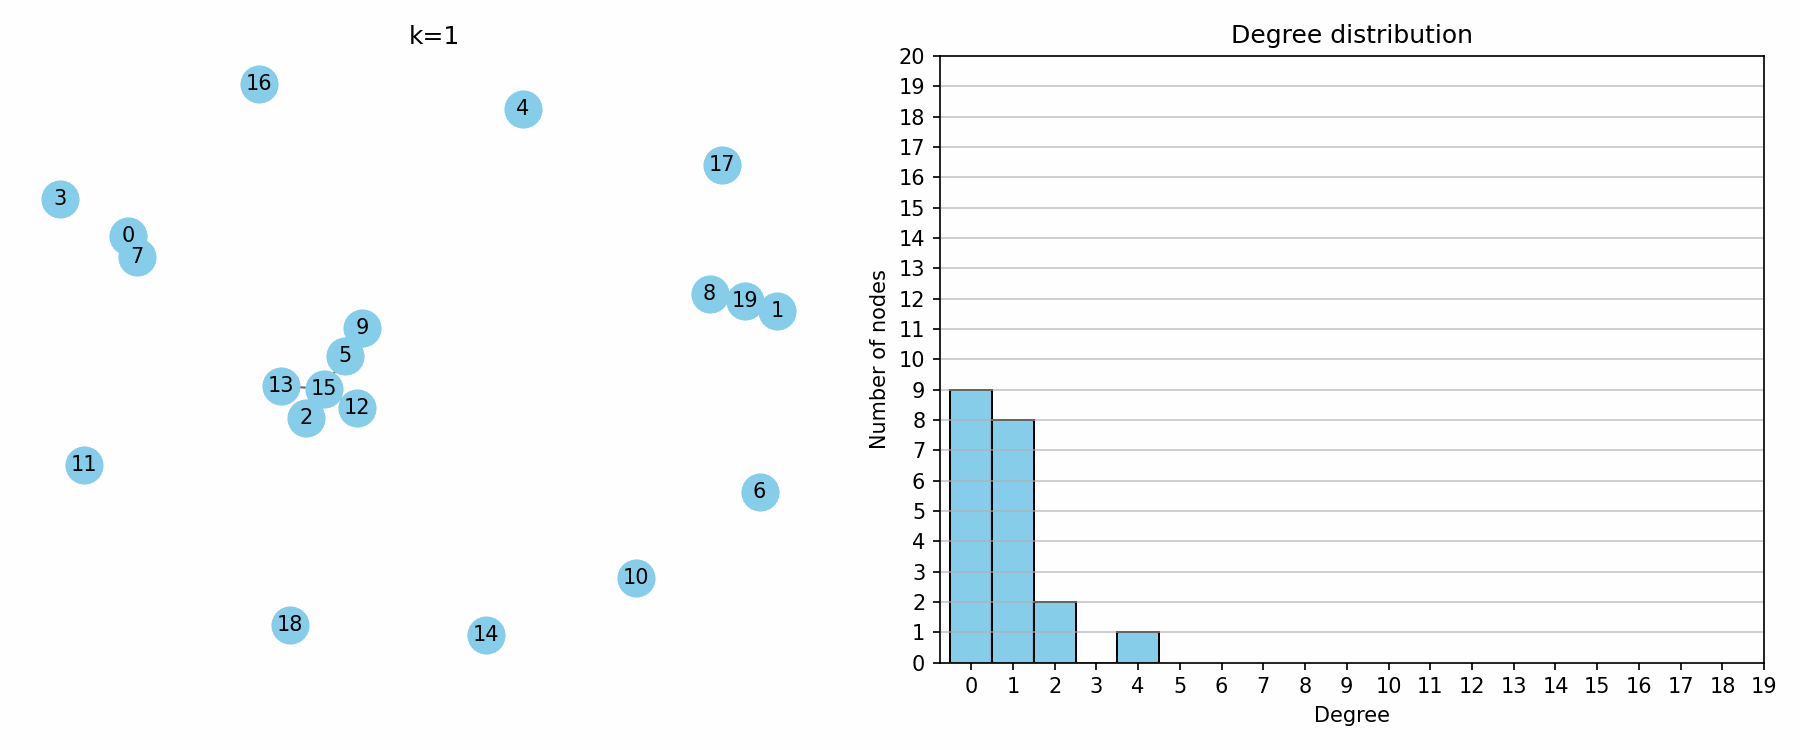

In [29]:
n = 20
p = 0.05
seed = 25
k_values = [i+1 for i in range(20)]

G_er = nx.gnp_random_graph(n=n, p=p, seed=seed)

generate_degree_anonymization_gif(
    G_original=G_er,
    social_anonymizer=social_anonymizer,
    k_values=k_values,
    output_dir=f"degree_frames_ER_n{n}_p{p}_seed{seed}")

display(Image(filename=f"degree_frames_ER_n{n}_p{p}_seed{seed}/degree_evolution.gif", width=700, height=300))

GIF saved to degree_frames_ER_n20_p0.05_seed41\degree_evolution.gif


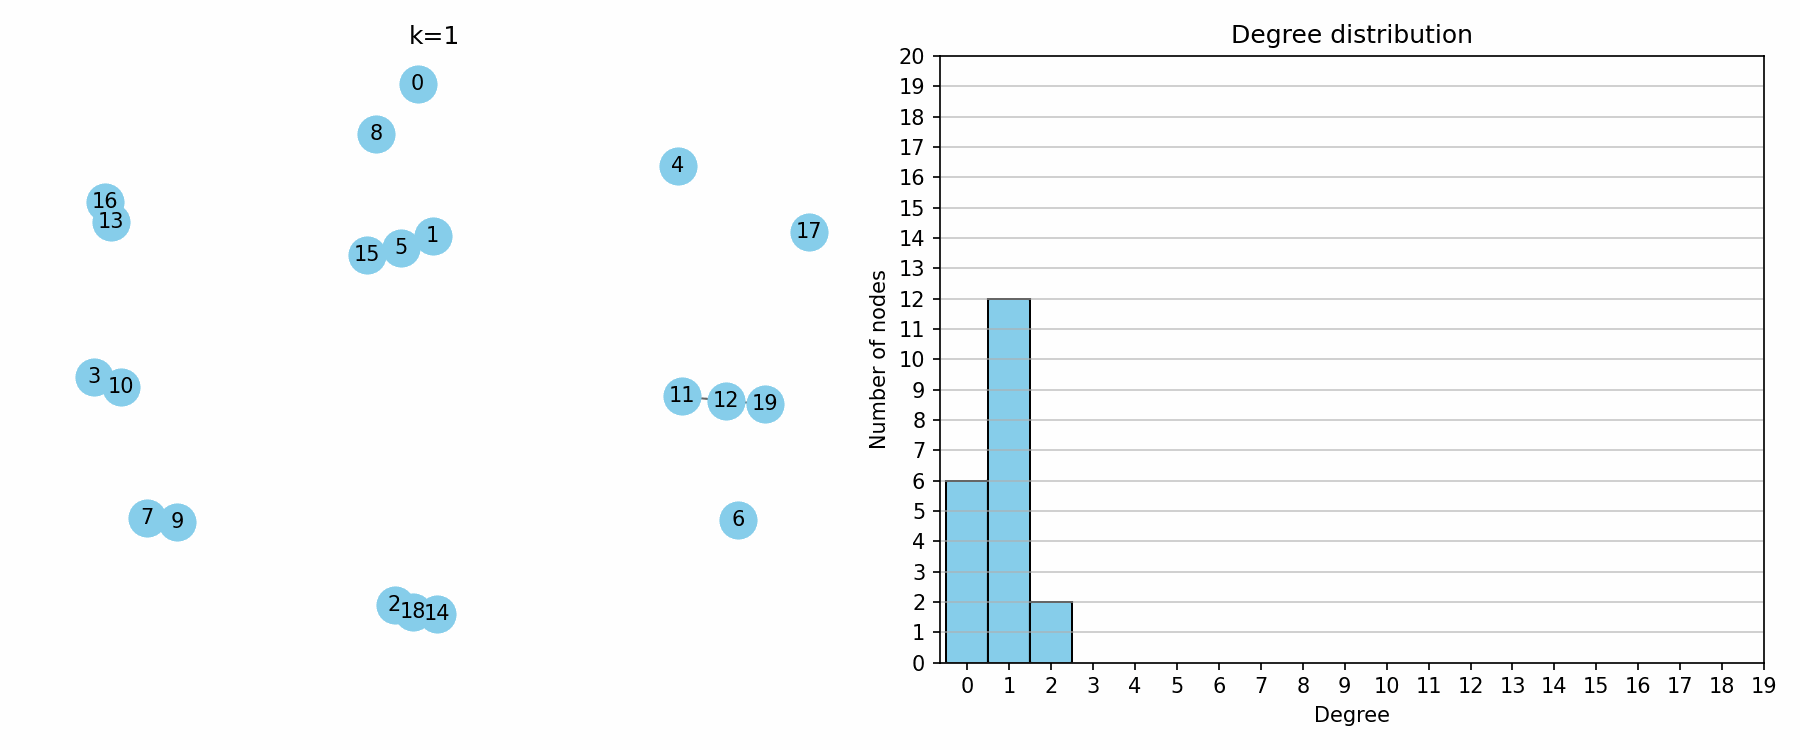

In [30]:
n = 20
p = 0.05
seed = 41
k_values = [i+1 for i in range(20)]

G_er = nx.gnp_random_graph(n=n, p=p, seed=seed)

generate_degree_anonymization_gif(
    G_original=G_er,
    social_anonymizer=social_anonymizer,
    k_values=k_values,
    output_dir=f"degree_frames_ER_n{n}_p{p}_seed{seed}")

display(Image(filename=f"degree_frames_ER_n{n}_p{p}_seed{seed}/degree_evolution.gif", width=700, height=300))

GIF saved to degree_frames_BA_n20_m1_seed49\degree_evolution.gif


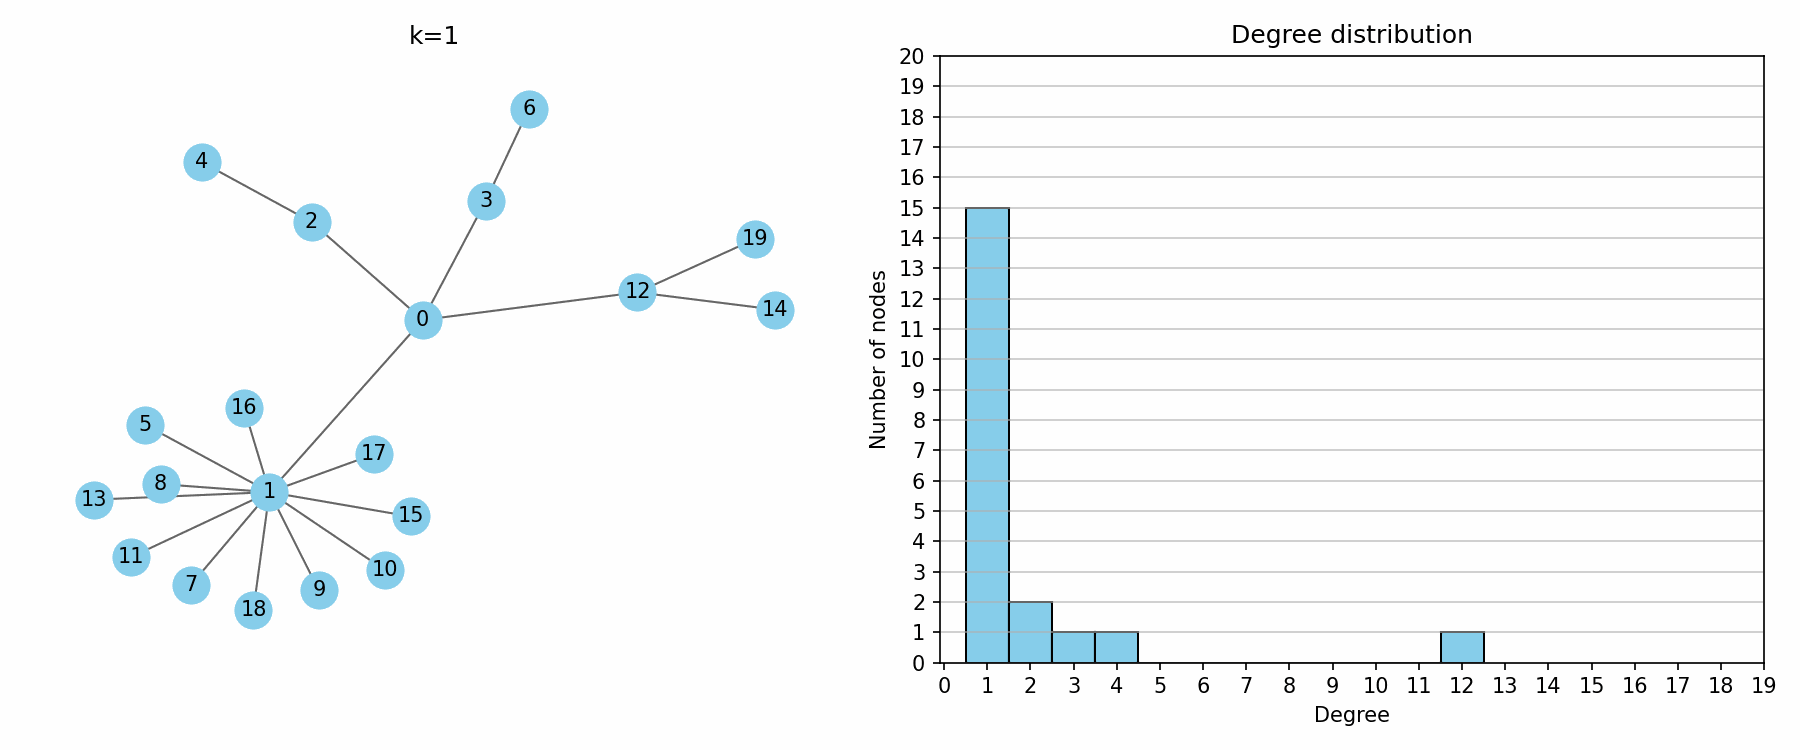

In [31]:
n = 20
m=1
seed = 49
k_values = [i+1 for i in range(20)]

G_ba = nx.barabasi_albert_graph(n=n, m=m, seed=seed)

generate_degree_anonymization_gif(
    G_original=G_ba,
    social_anonymizer=social_anonymizer,
    k_values=k_values,
    output_dir=f"degree_frames_BA_n{n}_m{m}_seed{seed}")

display(Image(filename=f"degree_frames_BA_n{n}_m{m}_seed{seed}/degree_evolution.gif", width=700, height=300))

Once k-anonymity is achieved, every node in the graph belongs to a group of at least k vertices that share isomorphic neighborhoods. Since a necessary condition for neighborhood isomorphism is having an equal number of vertices, these grouped nodes implicitly share the same degree. Consequently, no node retains a unique degree value that adversaries could exploit for re-identification, effectively preventing **degree attacks**. 

#### 2.2 Betweenness centrality

The distribution of betweenness in social networks is typically skewed, characterized by many nodes with low or zero betweenness and very few nodes with high betweenness (i.e., hubs). As k increases, this distribution tends to flatten and converge toward a single shared value. When k=∣V∣, every node possesses the exact same betweenness centrality value. Specifically, if the graph is anonymized into a clique, this value is equal to 0, because every node is directly connected to every other node, meaning no node acts as a bridge along a shortest path.   
A similar convergence pattern occurs in random graphs.

GIF saved to betweenness_frames_ER_n20_p0.05_seed25\betweenness_evolution.gif


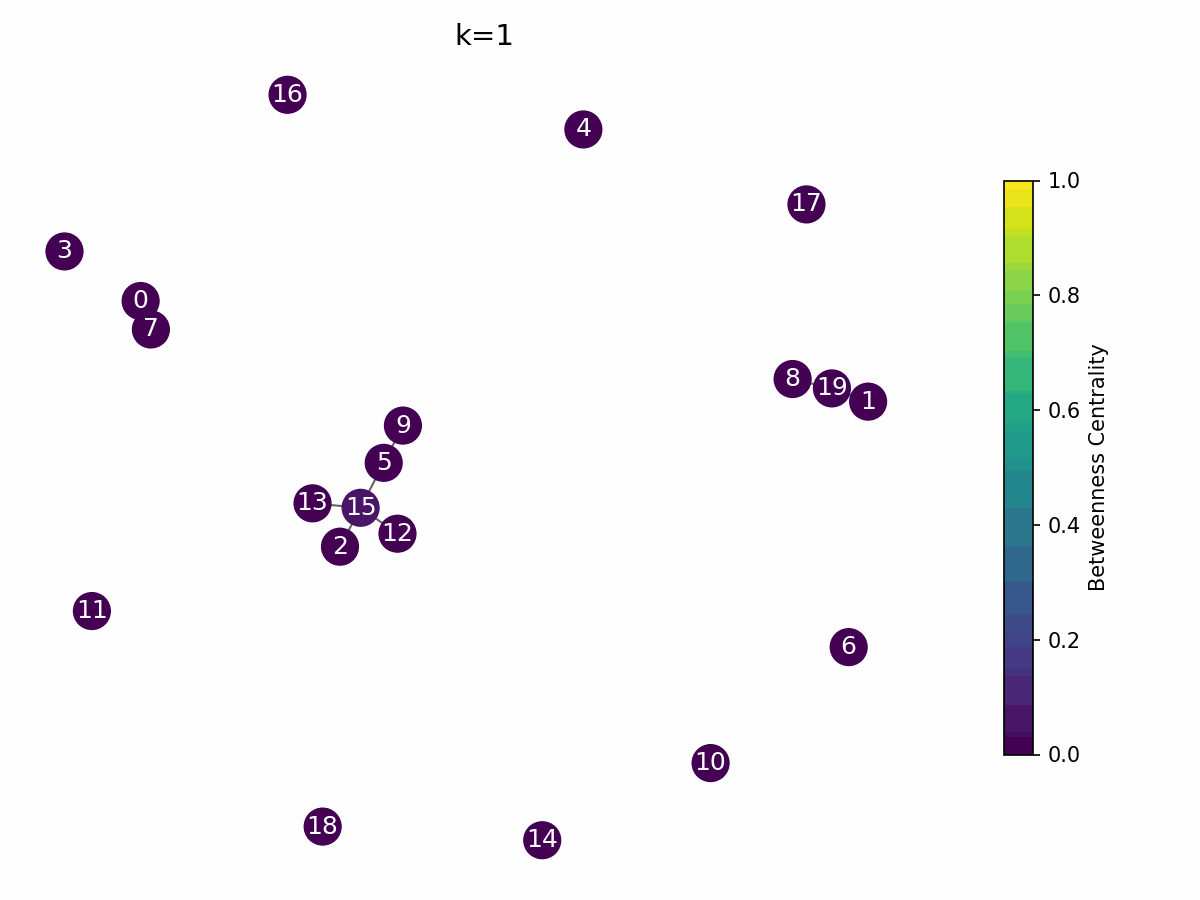

In [32]:
n = 20
p = 0.05
seed = 25
k_values = [i+1 for i in range(20)]

G_er = nx.gnp_random_graph(n=n, p=p, seed=seed)

generate_betweenness_anonymization_gif(
    G_original=G_er,
    social_anonymizer=social_anonymizer,
    k_values=k_values,
    output_dir=f"betweenness_frames_ER_n{n}_p{p}_seed{seed}",
)

display(Image(filename=f"betweenness_frames_ER_n{n}_p{p}_seed{seed}/betweenness_evolution.gif", width=500, height=300))

GIF saved to betweenness_frames_ER_n20_p0.05_seed41\betweenness_evolution.gif


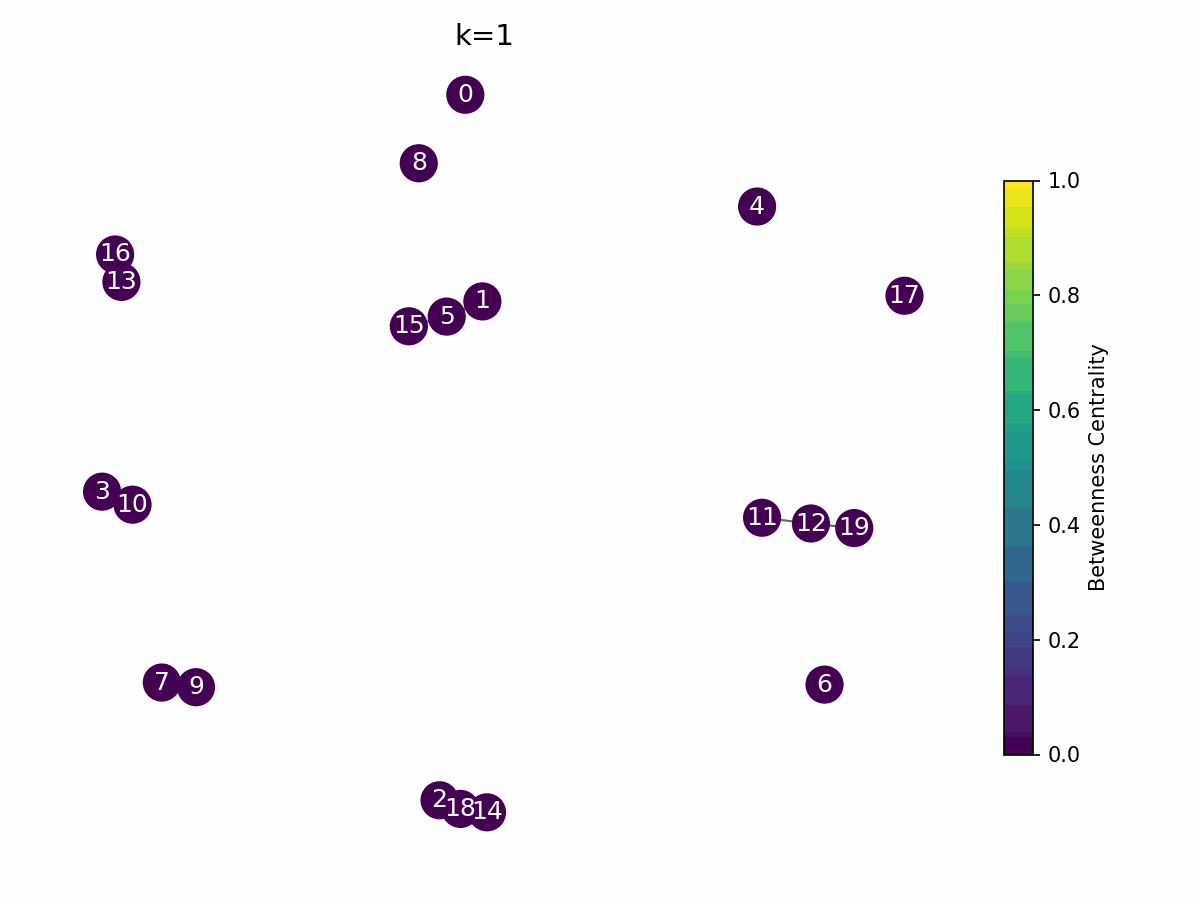

In [33]:
n = 20
p = 0.05
seed = 41
k_values = [i+1 for i in range(20)]

G_er = nx.gnp_random_graph(n=n, p=p, seed=seed)

generate_betweenness_anonymization_gif(
    G_original=G_er,
    social_anonymizer=social_anonymizer,
    k_values=k_values,
    output_dir=f"betweenness_frames_ER_n{n}_p{p}_seed{seed}",
)

display(Image(filename=f"betweenness_frames_ER_n{n}_p{p}_seed{seed}/betweenness_evolution.gif", width=500, height=300))

GIF saved to betweenness_frames_BA_n20_m1_seed49\betweenness_evolution.gif


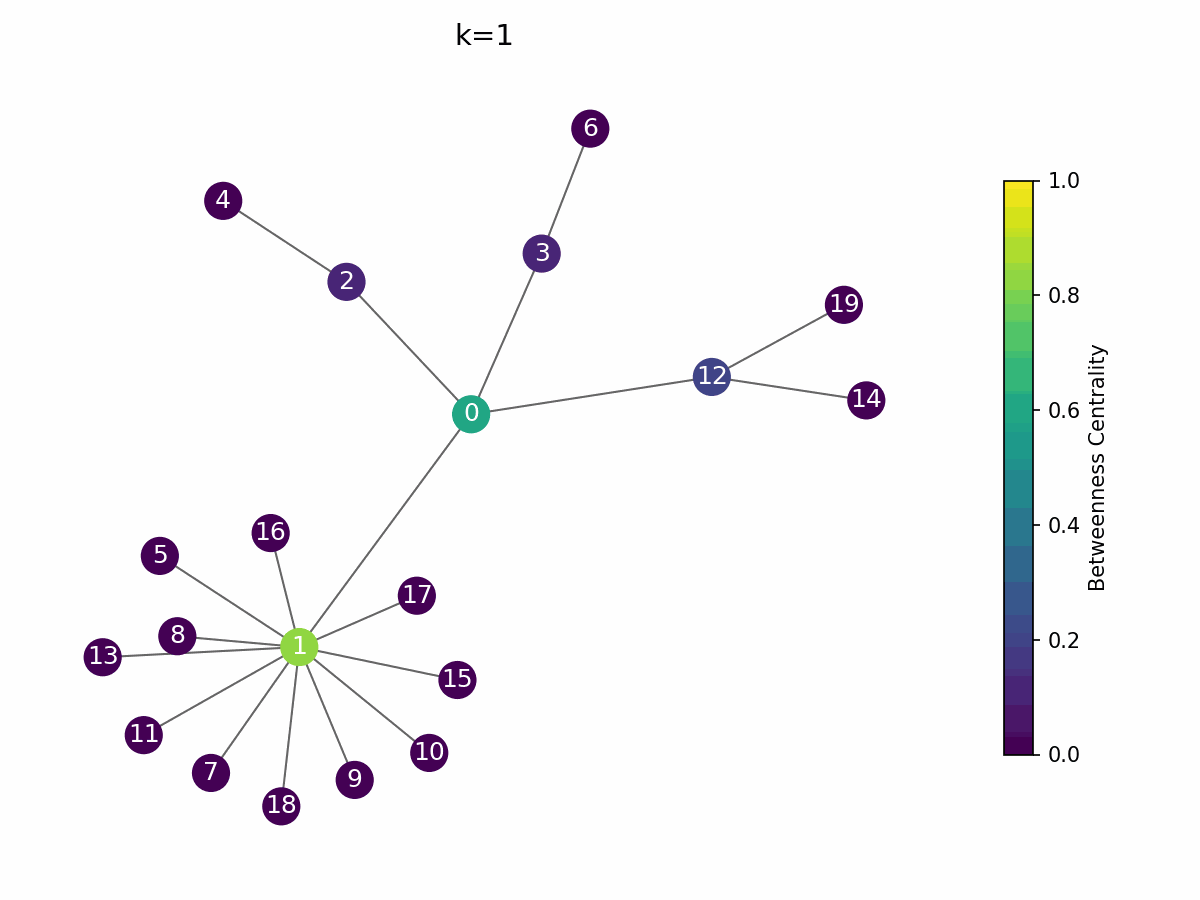

In [34]:
n = 20
m=1
seed = 49
k_values = [i+1 for i in range(20)]

G_ba = nx.barabasi_albert_graph(n=n, m=m, seed=seed)

generate_betweenness_anonymization_gif(
    G_original=G_ba,
    social_anonymizer=social_anonymizer,
    k_values=k_values,
    output_dir=f"betweenness_frames_BA_n{n}_m{m}_seed{seed}")

display(Image(filename=f"betweenness_frames_BA_n{n}_m{m}_seed{seed}/betweenness_evolution.gif", width=500, height=300))

Once k-anonymity is achieved, every node in the graph belongs to a group of at least k vertices that share isomorphic neighborhoods. However, this local constraint does not prevent nodes from holding unique global betweenness centrality values. Since the algorithm functions by adding edges, betweenness values are typically modified during the process. Therefore, even if an attacker possesses the exact original betweenness value of a victim, they usually cannot use it to identify the target because the value has shifted (regardless of whether the new value is unique).    
However, the modification of betweenness values is not guaranteed in all scenarios. Notable exceptions include:     
- Already k-anonymous graphs: If the original graph (or specific subsets of nodes) already satisfies the condition, the algorithm may make no changes. 
- Disconnected components: If a specific connected component requires no modification (e.g., it is isolated and internally k-anonymous), the betweenness values within it remain identical to the original graph.   

In these cases, if a node holds a unique betweenness value within the unchanged structure, re-identification is straightforward, assuming the attacker knows the victim's neighborhood structure and their exact betweenness. The fundamental issue is that nodes in the same equivalence class share identical local metrics but distinct global metrics.
Furthermore, even without unique values, negative disclosure may occur. Distinct subgroups within the same equivalence class may hold significantly different global metric values. An attacker can thus rule out specific nodes that clearly do not correspond to the victim, reducing the effective anonymity set size below k.     
Finally, attacks based on ranking are also feasible. If an attacker knows, for instance, that 'Alice is in the top 10% by betweenness,' and only one node in her equivalence class falls into that top tier, re-identification is possible. Even if multiple nodes (but not all) fall into that tier, the attacker gains information through negative disclosure.       

Thus, **betweenness attacks** remain a valid threat even after neighborhood anonymization. However, executing such attacks on large graphs poses practical challenges, as computing exact betweenness centrality for large networks is a computationally expensive operation.  

If the final betweenness values differ from the original values and the ranking is not guaranteed to be preserved, attacks based solely on exact background knowledge are rendered impossible, as the precise target values no longer exist in the graph. This scenario is highly probable in real-world social networks, which typically require extensive edge modifications to achieve anonymity due to their structural irregularity; it is rare for components, let alone the entire graph, to be pre-existing isomorphic structures left untouched by the algorithm. Consequently, probabilistic attacks (e.g., identifying the node with the closest matching value or the highest relative rank within an equivalence class) remain a significant and feasible threat.    
Let us consider an example. In the original social network, Alice is an important bridge with a betweenness score of 0.48. We anonymize the network adopting k=3. Consequently, Alice is grouped with two other nodes, Bob and Charlie, who share her anonymized neighborhood. Originally, Bob and Charlie were peripheral nodes with betweenness scores of 0.02 and 0.03, respectively.   
Due to anonymization, Alice's betweenness drops to 0.42, while Bob's and Charlie's increase to 0.14 and 0.15. The attacker, looking for the exact value 0.48, finds no match, and an exact attack fails. However, the attacker can calculate the betweenness for the three anonymized nodes (x,y,z) and compare them to the known prior (0.48):   
- Node x (0.42): ∣0.48−0.42∣=0.06
- Node y (0.14): ∣0.48−0.14∣=0.34
- Node z (0.15): ∣0.48−0.15∣=0.33    

The attacker knows that Alice was a major bridge. Anonymization adds topological noise, which usually dilutes centrality but rarely turns a global bridge into a peripheral node, nor does it typically turn a peripheral node into a global bridge (it merely makes them look similar locally). Node x is the only node in this group that retains a 'Bridge-like' score, even though it shifted from 0.48 to 0.42. Therefore, the attacker infers that Node x is Alice.     
Unless the algorithm essentially turns the whole group into a clique connected to the rest of the network, the relative ranking or the magnitude of the original node, if it held a strong role in terms of centrality, usually remains distinct enough for such probabilistic identification.

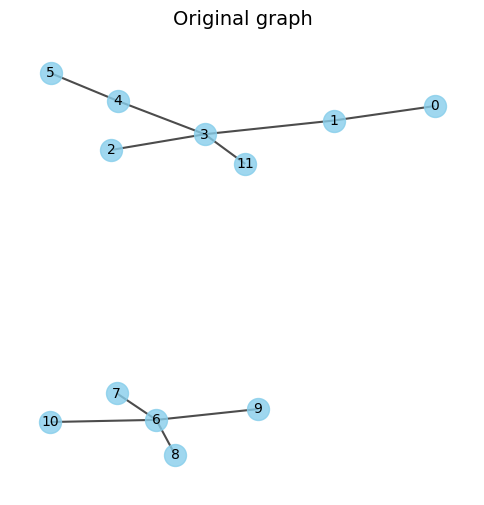

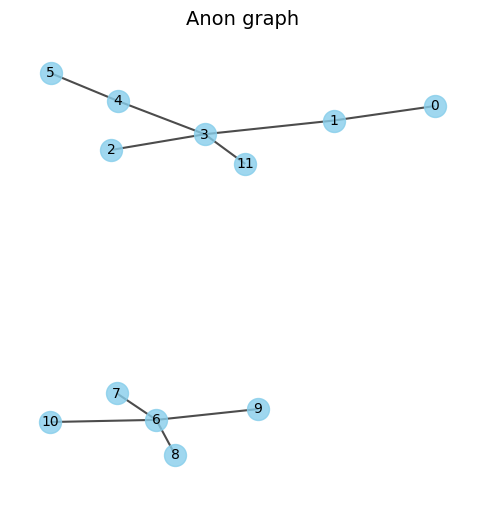

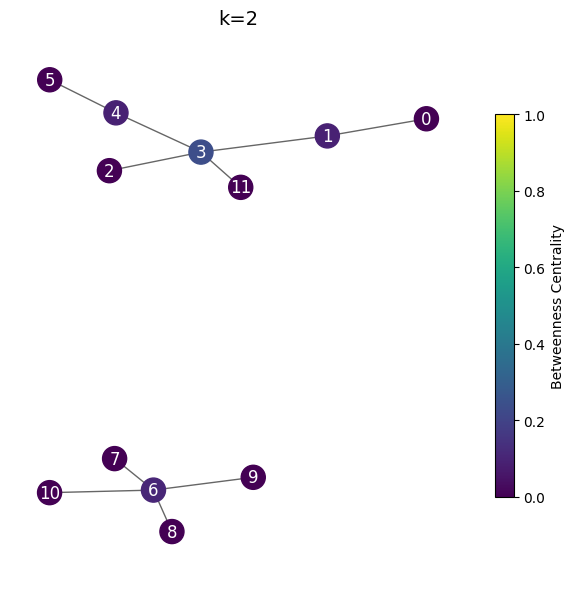

In [35]:
bet_attack_G = nx.Graph()

bet_attack_G.add_edges_from([(0, 1), (1, 3), (2, 3), (3, 4), (4, 5), (11, 3), (10, 6), (6, 9), (6, 8), (7, 6)])

plot_graph(bet_attack_G, "Original graph")

G_anon, eq_classes = social_anonymizer.anonymize_graph(bet_attack_G, k=2, alpha=0, beta=1, gamma=1)

# Optional: verify isomorphism
if len(check_isomorphic_classes(G_anon, eq_classes)) != 0:
    raise Exception(f"Anonymization for k={k} failed isomorphism check.")

plot_graph(G_anon, "Anon graph")

bc = nx.betweenness_centrality(G_anon, normalized=True)
bc_values = [bc[node] for node in bet_attack_G.nodes()]

# Create figure
fig, ax = plt.subplots(figsize=(6, 6))
pos = nx.spring_layout(G_anon, seed=42)

labels = {node: str(node) for node in G_anon.nodes()}

# Draw nodes with BC coloring
nx.draw_networkx_nodes(
    G_anon, pos, node_color=bc_values, cmap=plt.cm.viridis,
    node_size=300, ax=ax, vmin=0, vmax=1)
nx.draw_networkx_edges(G_anon, pos, ax=ax, alpha=0.6)
nx.draw_networkx_labels(G_anon, pos, labels=labels, font_color='white', ax=ax) #font_weight='bold',

ax.set_title(f"k=2", fontsize=14)
ax.axis("off")
        
# colorbar with fixed range
sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=0, vmax=1))
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, shrink=0.7)
cbar.set_label("Betweenness Centrality")

plt.tight_layout()
plt.show()

- Exact Value Attack: Although nodes 6 and 3 are grouped within the same equivalence class, their betweenness centrality values differ substantially (≈0.109 vs. ≈0.236). This discrepancy potentially enables an adversary to distinguish between them based on global structural information.
- Ranking Attack: Node 3 ranks first in the network (top ≈8%), while Node 6 ranks second (top ≈17%). An adversary with knowledge of this ranking can uniquely identify the nodes.   

Apart from the equivalence class [6, 3], all other equivalence classes exhibit homogeneous betweenness values; therefore, these types of structural disclosures are not possible for the rest of the graph.

#### 2.3 Closeness centrality

Closeness centrality tends to increase as k increases, because the addition of edges reduces average path lengths, effectively bringing nodes closer together. Similar to degree and betweenness centrality, when k=∣V∣, the metric adjusts to a single value shared by every node in the graph.    
If the anonymized graph converges to a clique, this value reaches the maximum of 1 (assuming normalized closeness). A clique represents the structural extreme of maximum closeness, where every node is directly connected to every other node, and minimum betweenness (0), as no node acts as a bridge along any shortest path. 

GIF saved to closeness_frames_ER_n20_p0.05_seed25\closeness_evolution.gif


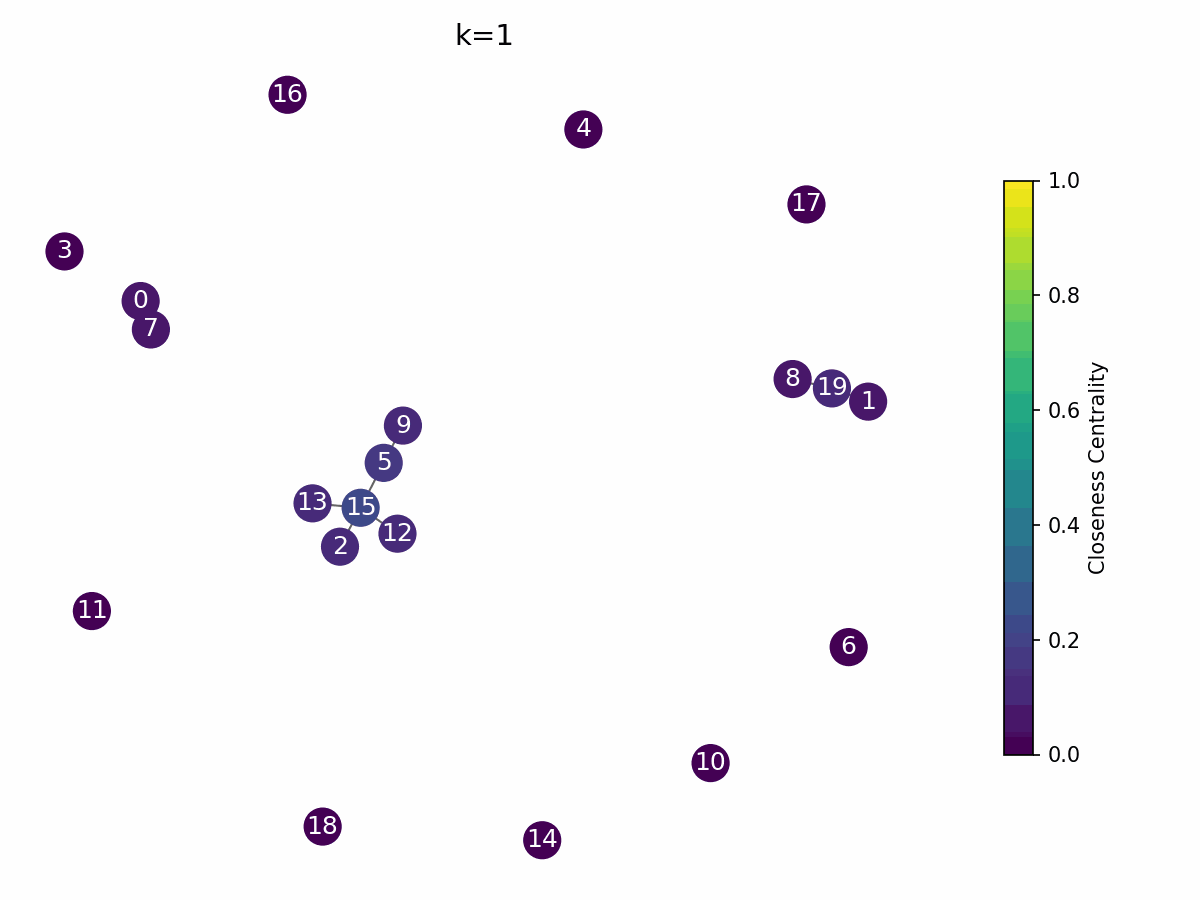

In [36]:
n = 20
p = 0.05
seed = 25
k_values = [i+1 for i in range(20)]

G_er = nx.gnp_random_graph(n=n, p=p, seed=seed)

generate_closeness_anonymization_gif(
    G_original=G_er,
    social_anonymizer=social_anonymizer,
    k_values=k_values,
    output_dir=f"closeness_frames_ER_n{n}_p{p}_seed{seed}",
)

display(Image(filename=f"closeness_frames_ER_n{n}_p{p}_seed{seed}/closeness_evolution.gif", width=500, height=300))

GIF saved to closeness_frames_ER_n20_p0.05_seed41\closeness_evolution.gif


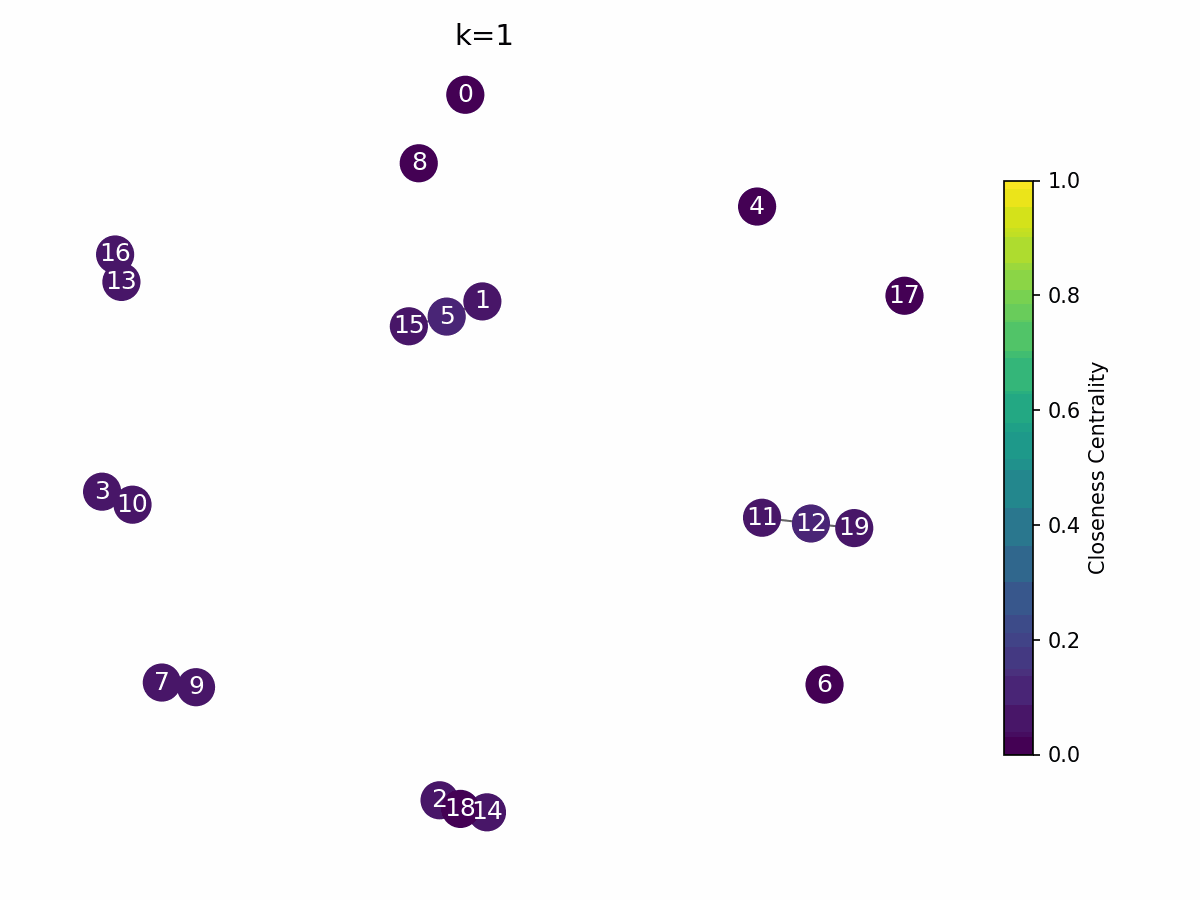

In [37]:
n = 20
p = 0.05
seed = 41
k_values = [i+1 for i in range(20)]

G_er = nx.gnp_random_graph(n=n, p=p, seed=seed)

generate_closeness_anonymization_gif(
    G_original=G_er,
    social_anonymizer=social_anonymizer,
    k_values=k_values,
    output_dir=f"closeness_frames_ER_n{n}_p{p}_seed{seed}",
)

display(Image(filename=f"closeness_frames_ER_n{n}_p{p}_seed{seed}/closeness_evolution.gif", width=500, height=300))

GIF saved to closeness_frames_BA_n20_m1_seed49\closeness_evolution.gif


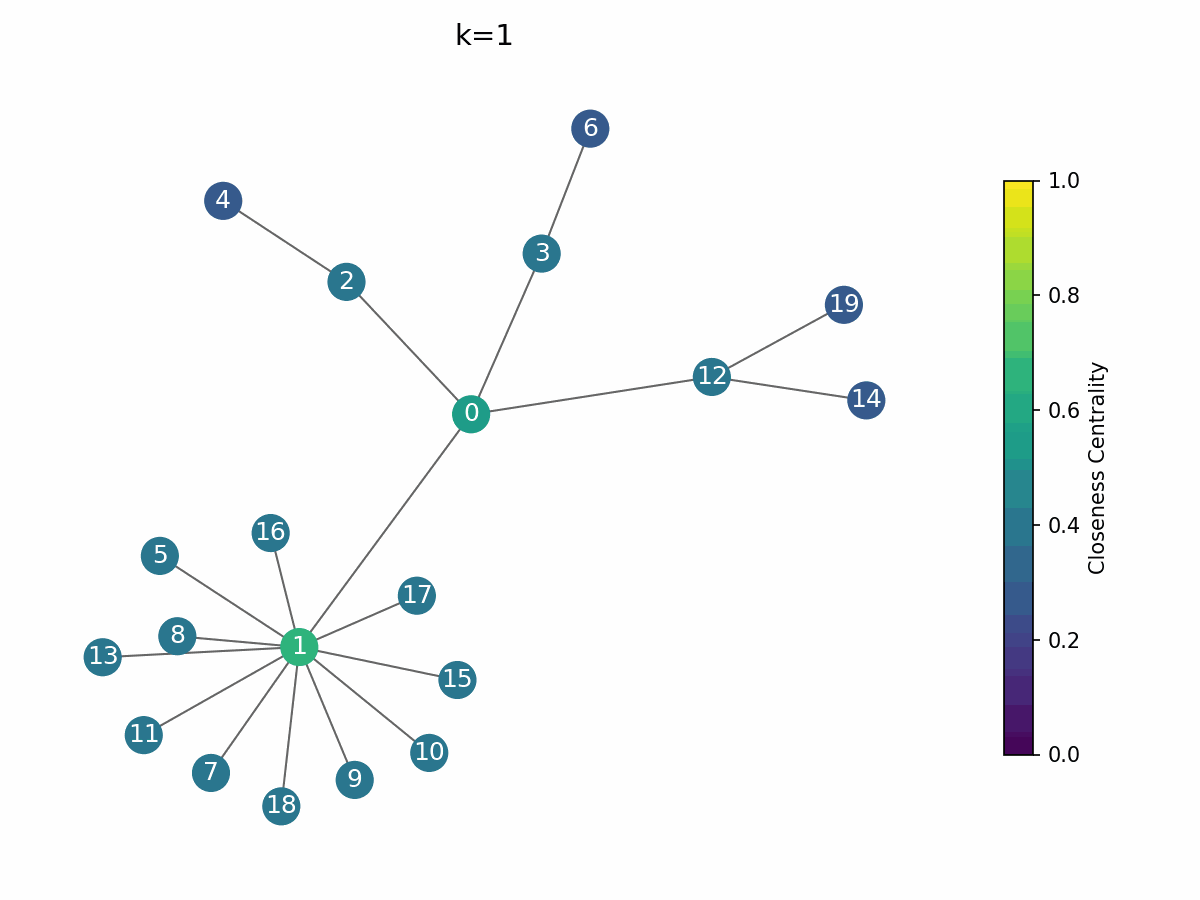

In [38]:
n = 20
m=1
seed = 49
k_values = [i+1 for i in range(20)]

G_ba = nx.barabasi_albert_graph(n=n, m=m, seed=seed)

generate_closeness_anonymization_gif(
    G_original=G_ba,
    social_anonymizer=social_anonymizer,
    k_values=k_values,
    output_dir=f"closeness_frames_BA_n{n}_m{m}_seed{seed}")

display(Image(filename=f"closeness_frames_BA_n{n}_m{m}_seed{seed}/closeness_evolution.gif", width=500, height=300))

Regarding Closeness Centrality, the same vulnerability considerations apply as with Betweenness Centrality, since both are global metrics relying on shortest-path information across the entire graph.    
However, a specific issue with closeness in social networks is that the numerical differences between vertices are typically very small (a consequence of the logarithmic growth of shortest paths in small-world networks). Closeness centrality values tend to be concentrated within a narrow range. This lack of granularity creates a practical difficulty for adversaries attempting exact value or ranking attacks.

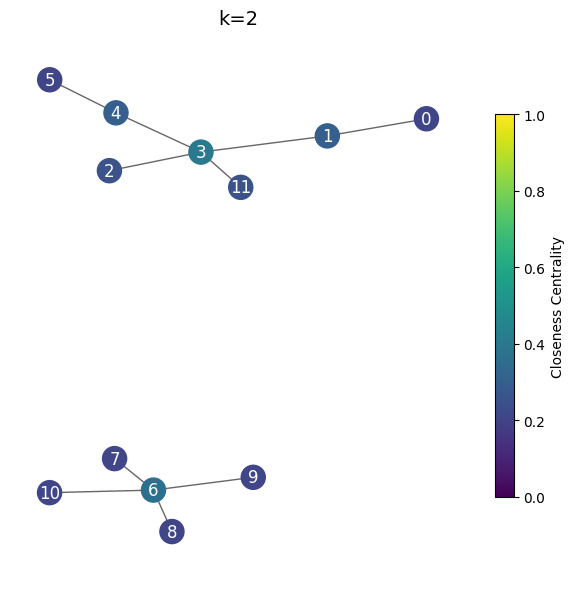

In [39]:
bet_attack_G = nx.Graph()

bet_attack_G.add_edges_from([(0, 1), (1, 3), (2, 3), (3, 4), (4, 5), (11, 3), (10, 6), (6, 9), (6, 8), (7, 6)])

cc = nx.closeness_centrality(G_anon)
cc_values = [cc[node] for node in G_anon.nodes()]

# Create figure
fig, ax = plt.subplots(figsize=(6, 6))
pos = nx.spring_layout(G_anon, seed=42)

labels = {node: str(node) for node in G_anon.nodes()}

# Draw nodes with BC coloring
nx.draw_networkx_nodes(
    G_anon, pos, node_color=cc_values, cmap=plt.cm.viridis,
    node_size=300, ax=ax, vmin=0, vmax=1)
nx.draw_networkx_edges(G_anon, pos, ax=ax, alpha=0.6)
nx.draw_networkx_labels(G_anon, pos, labels=labels, font_color='white', ax=ax) #font_weight='bold',

ax.set_title(f"k=2", fontsize=14)
ax.axis("off")
        
# colorbar with fixed range
sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=0, vmax=1))
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, shrink=0.7)
cbar.set_label("Closeness Centrality")

plt.tight_layout()
plt.show()

- Exact Value Attack: Although Node 3 and Node 6 have isomorphic neighborhoods, Node 3 is globally more central than Node 6. Their closeness centrality values differ (≈0.409 vs. ≈0.364). This discrepancy potentially enables an adversary to distinguish between them based on global structural information.    
- Ranking Attack: Node 3 ranks first in the network (top ≈8%), while Node 6 ranks second (top ≈17%). An adversary with knowledge of this ranking can uniquely identify the nodes.    

Moreover, negative disclosure is possible in other instances. Nodes within the same equivalence class may exhibit distinct closeness values. For example, in the group [0, 2, 5, 7, 8, 9, 10, 11], nodes 0 and 5 have a closeness of ≈0.205, while nodes 2 and 11 have a closeness of ≈0.252. This allows an adversary to rule out specific candidates within the group based on metric thresholds.

#### 2.4 Reachability

It is worth noting that standard Barabási–Albert graphs are connected by construction; therefore, reachability is primarily relevant when using random graphs as a baseline or when analyzing real-world social networks, which typically feature a giant component alongside smaller, isolated components.    
Generally, reachability tends to improve, and the number of connected components decreases, as k increases. However, it is not guaranteed that for k=∣V∣, the anonymized graph will always form a single connected component. In the context of social networks, the result is typically a single component. Due to the replication of hub neighborhoods, the anonymized graph usually saturates into a clique, which is inherently connected. Conversely, for sparse graphs without hubs (characterized by a low maximum degree, such as random graphs with small p), connectivity is not assured. For example, a sparse graph might converge into a structure consisting of multiple disjoint, identical rings. In such a scenario, every node possesses a neighborhood isomorphic to that of all other nodes (satisfying k=∣V∣), yet the graph remains disconnected.

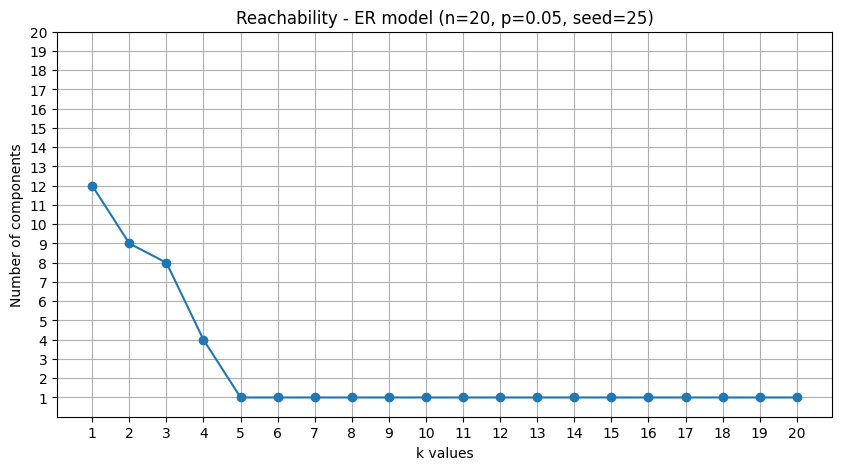

In [42]:
n = 20
p = 0.05
seed = 25
k_values = [i+1 for i in range(20)]

G_er = nx.gnp_random_graph(n=n, p=p, seed=seed)

num_components_by_k = []
for k in k_values:
    G_anon, eq_classes = social_anonymizer.anonymize_graph(G_er, k=k, alpha=0, beta=1, gamma=1)
    if len(check_isomorphic_classes(G_anon, eq_classes)) != 0:
        raise Exception(f"Anonymization for k={k} failed isomorphism check.")
    components = nx.connected_components(G_anon)
    num_components = len(list(components))
    num_components_by_k.append(num_components)

plt.figure(figsize=(10, 5))
plt.plot(k_values, num_components_by_k, marker='o')
plt.xlabel("k values")
plt.ylabel("Number of components")
plt.ylim(0, 1.1)
plt.title(f"Reachability - ER model (n={n}, p={p}, seed={seed})")
plt.xticks(k_values)
plt.yticks(range(1, n+1))
plt.grid(True)
plt.show()

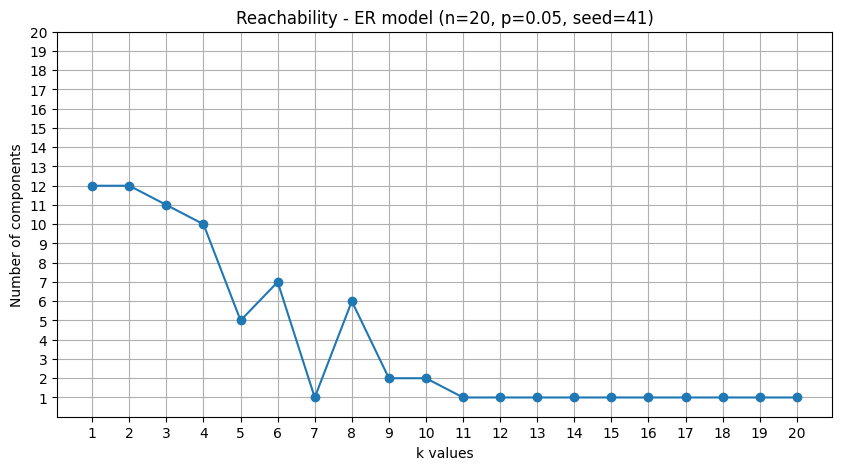

In [43]:
n = 20
p = 0.05
seed = 41
k_values = [i+1 for i in range(20)]

G_er = nx.gnp_random_graph(n=n, p=p, seed=seed)

num_components_by_k = []
for k in k_values:
    G_anon, eq_classes = social_anonymizer.anonymize_graph(G_er, k=k, alpha=0, beta=1, gamma=1)
    if len(check_isomorphic_classes(G_anon, eq_classes)) != 0:
        raise Exception(f"Anonymization for k={k} failed isomorphism check.")
    components = nx.connected_components(G_anon)
    num_components = len(list(components))
    num_components_by_k.append(num_components)

plt.figure(figsize=(10, 5))
plt.plot(k_values, num_components_by_k, marker='o')
plt.xlabel("k values")
plt.ylabel("Number of components")
plt.ylim(0, 1.1)
plt.title(f"Reachability - ER model (n={n}, p={p}, seed={seed})")
plt.xticks(k_values)
plt.yticks(range(1, n+1))
plt.grid(True)
plt.show()

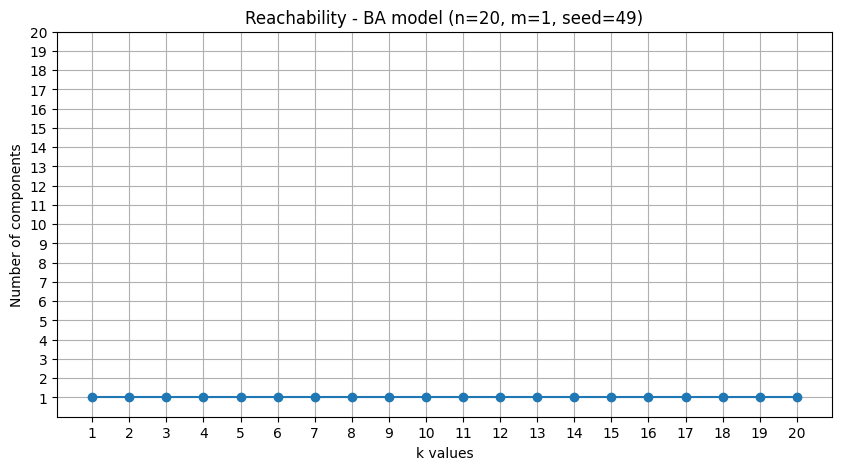

In [44]:
n = 20
m=1
seed = 49
k_values = [i+1 for i in range(20)]

G_ba = nx.barabasi_albert_graph(n=n, m=m, seed=seed)

num_components_by_k = []
for k in k_values:
    G_anon, eq_classes = social_anonymizer.anonymize_graph(G_ba, k=k, alpha=0, beta=1, gamma=1)
    if len(check_isomorphic_classes(G_anon, eq_classes)) != 0:
        raise Exception(f"Anonymization for k={k} failed isomorphism check.")
    components = nx.connected_components(G_anon)
    num_components = len(list(components))
    num_components_by_k.append(num_components)

plt.figure(figsize=(10, 5))
plt.plot(k_values, num_components_by_k, marker='o')
plt.xlabel("k values")
plt.ylabel("Number of components")
plt.ylim(0, 1.1)
plt.title(f"Reachability - BA model (n={n}, m={m}, seed={seed})")
plt.xticks(k_values)
plt.yticks(range(1, n+1))
plt.grid(True)
plt.show()

Reachability, defined here as the size of the connected component to which a node belongs, is a global property of the graph rather than a local property of individual nodes. Consequently, as previously discussed, local neighborhood isomorphism is insufficient to mask the global structural relevance of a node.   
Attacks based solely on reachability are feasible only if the anonymized graph consists of multiple disconnected components of different sizes. Conversely, if the graph is fully connected (e.g., if it saturates into a single clique), reachability attacks are impossible because every node shares the same reachability scope (the entire graph).   

Let us consider an example of negative disclosure based on reachability. Imagine a graph G constructed from the disjoint union of two rings of different sizes: a Square (C4) and a Hexagon (C6). This graph is locally isomorphic (satisfying k=∣V∣ for 1-neighborhoods), meaning no edge addition is required for anonymization. Every node appears locally identical. However, if an adversary possesses background knowledge regarding the community size of the victim (e.g., 'Alice belongs to a small isolated team of 4 people'), they can execute a reachability attack. By calculating the component sizes in the anonymized graph, the adversary can identify the component of size 4. As a result, they successfully narrow down the victim to the 4 nodes in C4, excluding the 6 nodes in C6. This effectively breaks the global anonymity set; even if the adversary cannot uniquely identify Alice, they obtain negative disclosure.


### 3. Queryability

The two modifications employed by the algorithm impact queryability in distinct ways:
- **Edge addition**: This affects queryability by altering the topological veracity of the data, thereby changing query outputs. While queries such as 'number of edges' or 'top-k nodes by centrality' remain feasible, they will likely yield different results compared to the original graph.
- **Label generalization**: This affects queryability by causing a loss of data granularity, similar to k-anonymity in multidimensional data, which potentially reduces the query space for the anonymized graphs.   

We focus here on the first aspect, as label generalization is not fully integrated into the current algorithmic analysis. Graph queryability measures the extent to which the results of queries executed on an anonymized graph resemble those obtained from the original graph. The goal is to quantify the distortion—how much the answer to a query changes—due to the anonymization process.   
The first step is the identification of a query set for analysis:
1. Degree centrality
2. Local clustering coefficient
3. Betweenness centrality
4. Closeness centrality
5. Number of edges 

For queries returning a scalar value, distortion is quantified using relative error. For queries returning a vector of values (e.g., degree centrality scores for all nodes), there are several methods to quantify variation. We will use top-k overlap (intersection size) as the error metric, which measures the fraction of nodes common to the top-k rankings of the original and anonymized graphs.    
Finally, analyzing query error on social networks (using the Barabási–Albert model) in isolation provides limited insight. Therefore, we will compare the query error observed in social networks against the distortion observed in random graphs to benchmark the impact of topology.

In [45]:
def queryability_func(G_orig, G_anon, top_k):
    errors = compute_perquery_errors(G_orig, G_anon, top_k=top_k)
    score = compute_queryability_score(errors, weights=None)
    return 1 - score  # invert so high = better queryability

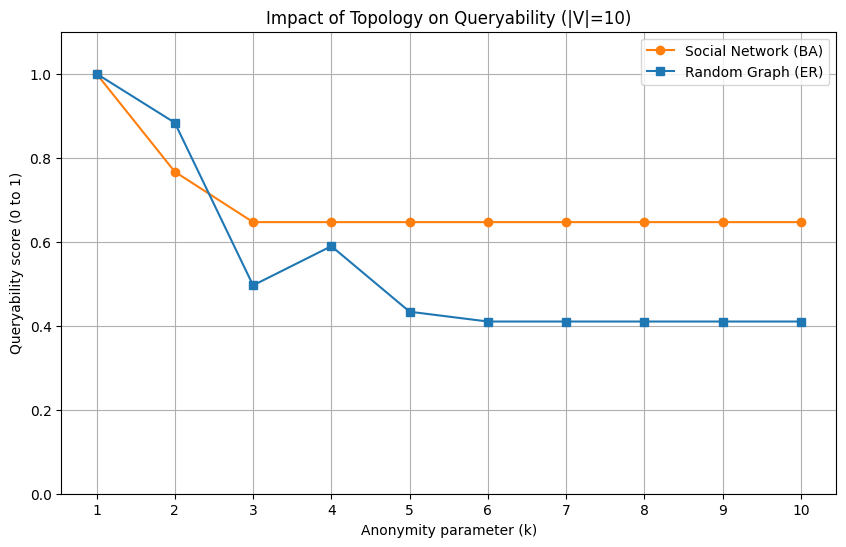

In [48]:
n = 10  
m = 1
top_k = 3 # heuristic rule 20-30% of the number of nodes
k_values = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]  # Up to k=N 
seeds = [2, 4, 14, 16, 23, 24, 29, 30, 31, 36]
num_seeds = len(seeds)

ba_quer_score, er_quer_score = run_metric_comparison_experiment(
    n=n,
    m=m,
    k_values=k_values,
    seeds=seeds,
    num_seeds=num_seeds,
    experiment_func=queryability_func,
    top_k=top_k
)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(k_values, ba_quer_score, marker='o', color='tab:orange', label='Social Network (BA)')
plt.plot(k_values, er_quer_score, marker='s', color='tab:blue', label='Random Graph (ER)')
plt.xlabel("Anonymity parameter (k)")
plt.ylabel("Queryability score (0 to 1)")
plt.title(f"Impact of Topology on Queryability (|V|={n})")
plt.ylim(0, 1.1)
plt.xticks(k_values)
plt.legend()
plt.grid(True)
plt.show()


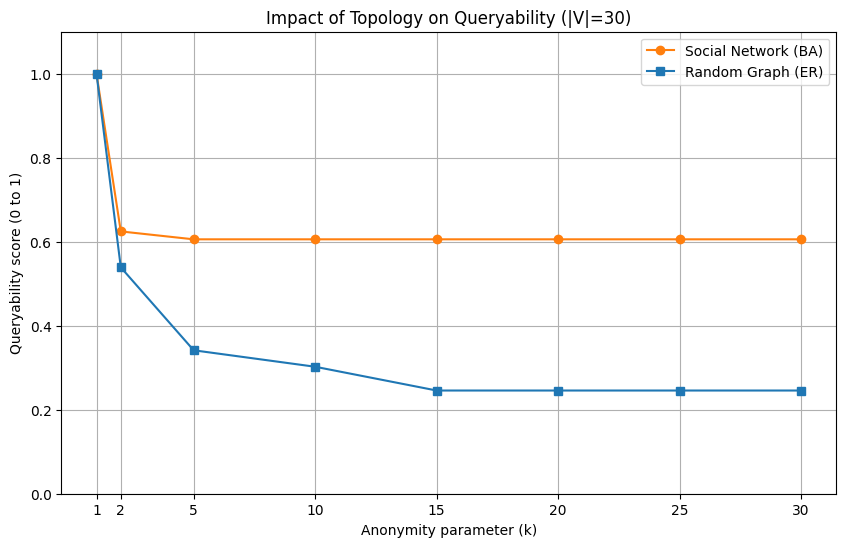

In [49]:
n = 30
m = 1
top_k = 7 # heuristic rule 20-30% of the number of nodes
k_values = [1, 2, 5, 10, 15, 20, 25, 30] # Up to k=N
seeds = [2, 3, 4, 6, 8, 10, 13, 14, 16, 17]
num_seeds = len(seeds)

ba_quer_score, er_quer_score = run_metric_comparison_experiment(
    n=n,
    m=m,
    k_values=k_values,
    seeds=seeds,
    num_seeds=num_seeds,
    experiment_func=queryability_func,
    top_k=top_k
)

plt.figure(figsize=(10, 6))
plt.plot(k_values, ba_quer_score, marker='o', color='tab:orange', label='Social Network (BA)')
plt.plot(k_values, er_quer_score, marker='s', color='tab:blue', label='Random Graph (ER)')
plt.xlabel("Anonymity parameter (k)")
plt.ylabel("Queryability score (0 to 1)")
plt.title(f"Impact of Topology on Queryability (|V|={n})")
plt.ylim(0, 1.1)
plt.xticks(k_values)
plt.legend()
plt.grid(True)
plt.show()

If we conceptualize the edge additions required for anonymization as structural perturbations, we can draw parallels to established graph theory literature (e.g., Albert et al., 2000). Scale-free networks (such as the Barabási-Albert model) are known to be robust to random changes due to their heavy-tailed degree distribution and hierarchical structure. In contrast, Erdős-Rényi (ER) graphs are significantly more sensitive to perturbations because they lack strong hubs; their structural homogeneity means that even minor modifications can drastically alter relative node rankings.    
This theoretical framework is consistent with our empirical results: query errors are, on average, significantly larger in random graphs than in scale-free networks as k increases. The observed robustness of BA networks can thus be attributed to the stability of their hubs, which preserves node centrality and topological structure even under the distortive effects of anonymization.

### 4. Privacy vs Utility

The trade-off between privacy and utility is evident in this scenario:
- **Highest utility, lowest privacy**: The original graph.
- **Highest privacy, lowest utility**: A clique where every node label is generalized to '\*'.     

As previously discussed, we adopt two modifications for anonymization: one is **perturbative** (the addition of edges, which alters the topological veracity of the data) and one is **non-perturbative** (the generalization of node labels, which reduces precision but maintains truthfulness).     

Even though the anonymization algorithm is prone to forming cliques due to its construction, it is worth noting that, in principle, enforcing k=∣V∣ does not theoretically guarantee a clique. Technically, it guarantees a regular graph where all neighborhoods are isomorphic (e.g., a ring) and every node holds the same label. Let us define such graphs as **locally isomorphic graphs**. Indeed, graph regularity is a necessary condition for k=∣V∣ (as degrees must match), but it is not a sufficient one.   
While all cliques are locally isomorphic graphs, not all locally isomorphic graphs are cliques. For this reason, in sparse graphs (e.g., random graphs with small p), the result might be a sparse regular structure that satisfies local isomorphism without saturating into a clique. However, in social networks, the anonymized graph frequently converges to a clique. This occurs because the anonymization algorithm replicates the neighborhoods of hubs (high-degree nodes). This forces the addition of massive numbers of edges to the rest of the network, causing the anonymized graph to converge to the clique (the densest possible locally isomorphic graph).   

We can define a normalized global metric (implemented as `compute_global_loss` in `utils.py`) representing the information loss produced by anonymization. This metric combines the normalized number of edges added to the graph and the level of label generalization (measured via the Normalized Certainty Penalty). This aggregate loss ranges from 0 (original graph) to 1 (a clique with all labels generalized to '\*'). As a consequence of the factors discussed above, when analyzing the global loss metric for increasing k (up to k=∣V∣), it is common for social networks to reach the maximum loss of 1 very quickly (i.e., even for low values of k). However, it is not surprising to observe that for networks without hubs, the loss may converge to a value smaller than 1, indicating that a locally isomorphic graph with fewer edges than a clique has been formed.    

If an adversary possesses knowledge about the neighbors of a target individual and the connectivity among those neighbors, the victim may be re-identified from a social network even if their identity has been preserved using conventional anonymization techniques; this is known as a neighborhood attack. Under the k-anonymity definition presented in the paper, the goal is to ensure the probability of re-identification is at most 1/k. For instance, while k=1 implies the attacker has 100% confidence in re-identifying a unique target, increasing k to 4 reduces this confidence to 25%. Naturally, this privacy gain comes at the cost of data utility, and the desired balance depends heavily on the application scenario.   

As shown in the following plots, this anonymization algorithm generally offers trade-off solutions that lie between the original graph (loss: 0) and a clique with suppressed labels (loss: 1). However, the effectiveness of these solutions and the rate of utility loss depend highly on the specific topology of the input graph.

#### 4.1 Ring example

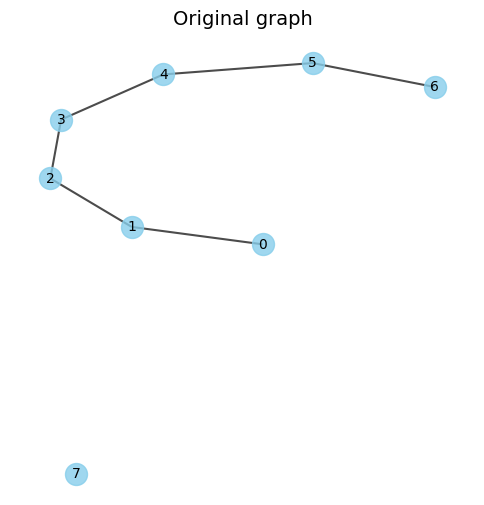

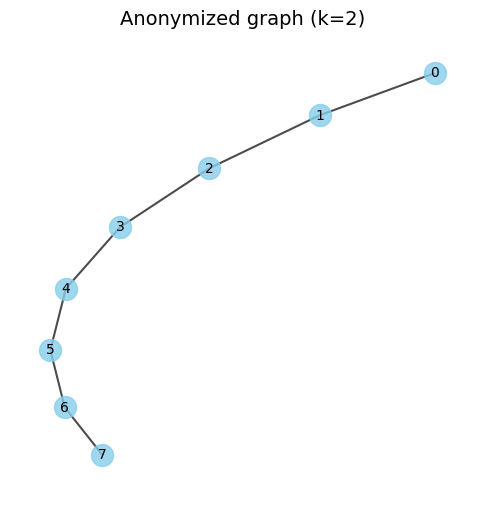

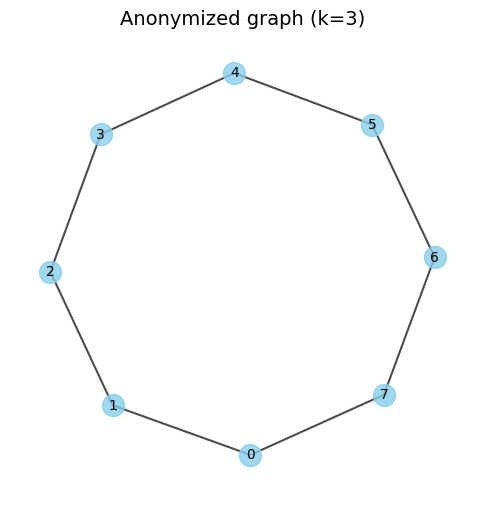

In [50]:
example_G = nx.Graph()
example_G.add_nodes_from(range(8))
example_G.add_edges_from([(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6)])

G_anon_k2, _ = social_anonymizer.anonymize_graph(example_G, k=2, alpha=0, beta=1, gamma=1)

G_anon_k3, _ = social_anonymizer.anonymize_graph(example_G, k=3, alpha=0, beta=1, gamma=1)

plot_graph(example_G, "Original graph")
plot_graph(G_anon_k2, "Anonymized graph (k=2)")
plot_graph(G_anon_k3, "Anonymized graph (k=3)")

When k=3, the anonymization process produces a ring structure. Since all vertices are structurally equivalent, the graph also satisfies k=8.

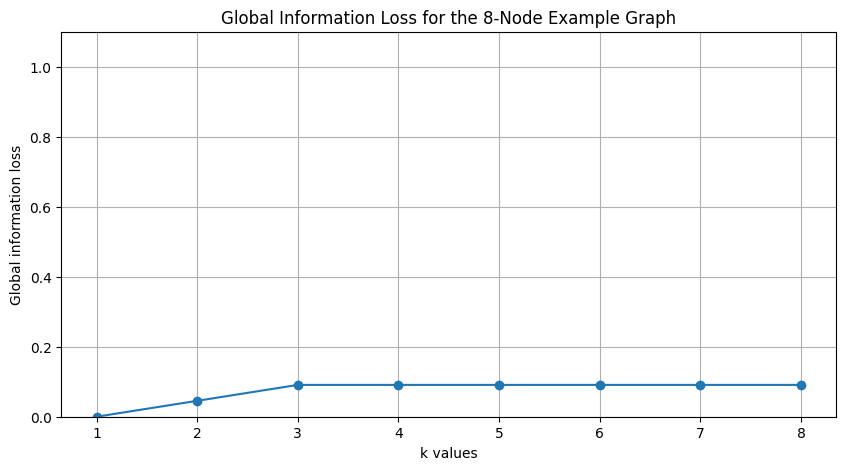

In [51]:
k_values = [i for i in range(1, example_G.number_of_nodes()+1)]
losses = []

for k in k_values:
    G_anon, _ = social_anonymizer.anonymize_graph(example_G, k=k, alpha=0, beta=1, gamma=1)
    losses.append(compute_global_loss(example_G, G_anon))

plt.figure(figsize=(10, 5))
plt.plot(k_values, losses, marker='o')
plt.xlabel(f"k values")
plt.ylabel("Global information loss")
plt.title(f"Global Information Loss for the {example_G.number_of_nodes()}-Node Example Graph")
plt.ylim(0, 1.1)
plt.xticks(k_values)
plt.grid(True)
plt.show()

As expected, the global loss converges to a value smaller than 1.

#### 4.2. Erdős–Rényi model example

In the following, we analyze an example illustrating the privacy–utility trade-off in a random graph as the edge probability p varies.

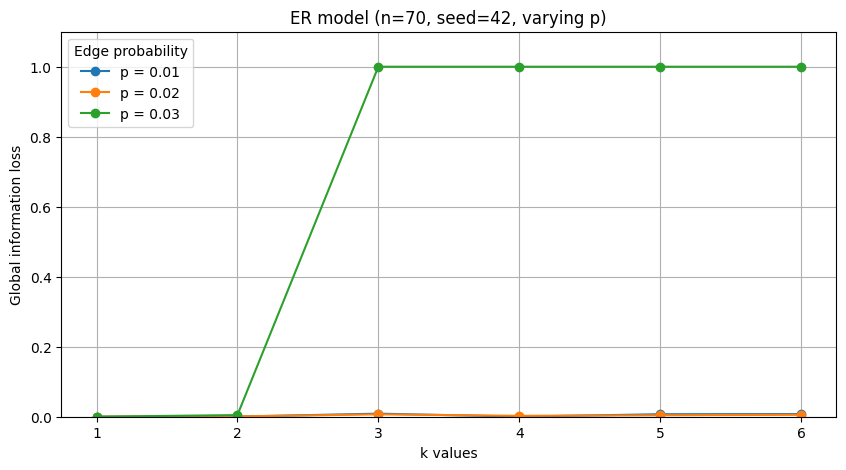

In [53]:
k_values = [1, 2, 3, 4, 5, 6]
p_values = [0.01, 0.02, 0.03]
n = 70
seed = 42

plt.figure(figsize=(10, 5))

for p in p_values:
    losses = []
    
    for k in k_values:
        G_random = nx.gnp_random_graph(n=n, p=p, seed=seed)
        G_anon, _ = social_anonymizer.anonymize_graph(G_random, k=k, alpha=0, beta=1, gamma=1)
        losses.append(compute_global_loss(G_random, G_anon))
    
    plt.plot(k_values, losses, marker='o', label=f"p = {p}")

plt.xlabel("k values")
plt.ylabel("Global information loss")
plt.ylim(0, 1.1)
plt.title(f"ER model (n={n}, seed={seed}, varying p)")
plt.xticks(k_values)
plt.legend(title="Edge probability")
plt.grid(True)
plt.show()


For p=0.03, corresponding to an average degree ⟨k⟩=p(N−1)≈2, the algorithm already saturates the anonymized graph into a clique already at k=3.   
We therefore investigate the behavior for increasing values of k up to |V|=70.

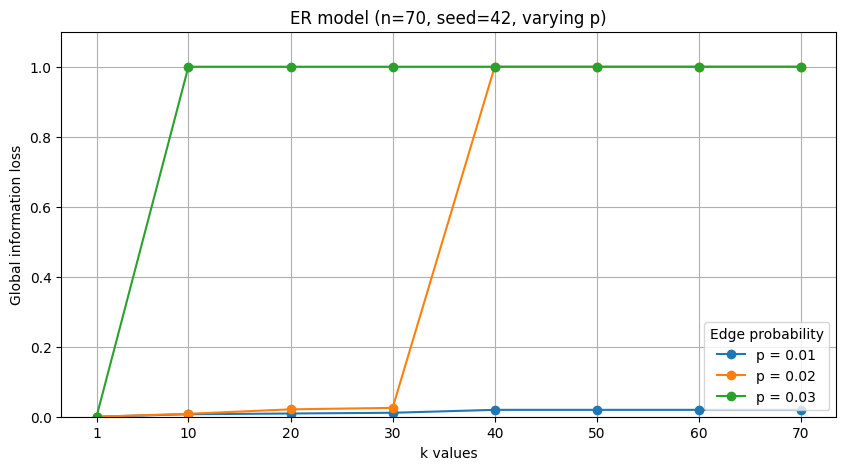

In [54]:
k_values = [1, 10, 20, 30, 40, 50, 60, 70]
p_values = [0.01, 0.02, 0.03]
n = 70
seed = 42

plt.figure(figsize=(10, 5))

for p in p_values:
    losses = []
    
    for k in k_values:
        G_random = nx.gnp_random_graph(n=n, p=p, seed=seed)
        G_anon, _ = social_anonymizer.anonymize_graph(G_random, k=k, alpha=0, beta=1, gamma=1)
        losses.append(compute_global_loss(G_random, G_anon))
    
    plt.plot(k_values, losses, marker='o', label=f"p = {p}")

plt.xlabel("k values")
plt.ylabel("Global information loss")
plt.ylim(0, 1.1)
plt.title(f"ER model (n={n}, seed={seed}, varying p)")
plt.xticks(k_values)
plt.legend(title="Edge probability")
plt.grid(True)
plt.show()

For all considered edge probabilities p, the global loss converges to 1, with the exception of p=0.01, corresponding to an average degree ⟨k⟩=p(N−1)≈0.69.    
Moreover, given `k_values=[1, 10, 20, 30, 40, 50, 60, 70]`:
- For p=0.01, all k values in `k_values` (apart from 1) are intermediate trade-off solutions between privacy and utility.   
- For p=0.02, only `[10, 20]` in `k_values` are intermediate trade-off solutions between privacy and utility.     
- For p=0.03, there is not valid intermediate trade-off solution between privacy and utility in `k_values`. 

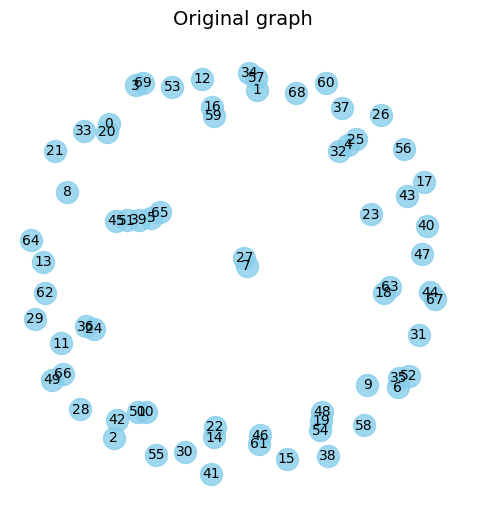

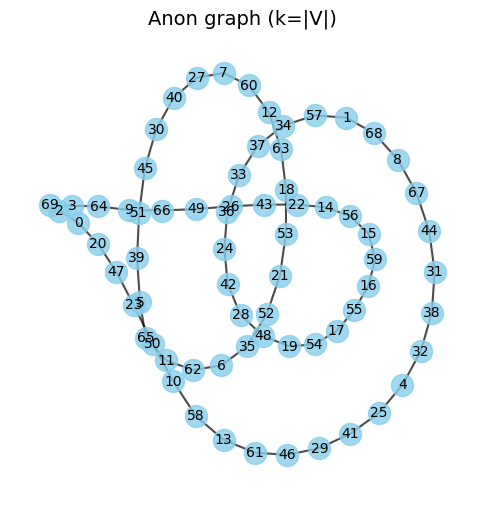

Average degree: 2.0


In [55]:
G_random = nx.gnp_random_graph(n=n, p=0.01, seed=seed)
G_anon, _ = social_anonymizer.anonymize_graph(G_random, k=n, alpha=0, beta=1, gamma=1)
plot_graph(G_random, "Original graph")
plot_graph(G_anon, "Anon graph (k=|V|)")
avg_degree = sum(dict(G_anon.degree()).values()) / G_anon.number_of_nodes()
print(f"Average degree: {avg_degree}")

The anonymization process again produces a ring graph, exhibiting local isomoprhism.    

#### 4.3. Barabási–Albert model example

We now discuss an example that illustrates the privacy–utility trade-off for Barabási–Albert graphs with different values of the attachment parameter m.

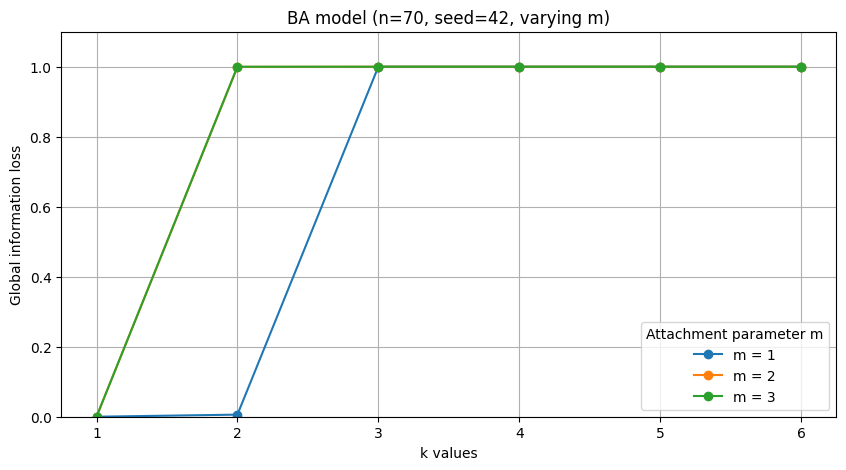

In [57]:
k_values = [1, 2, 3, 4, 5, 6]
m_values = [1, 2, 3]
n = 70
seed = 42

plt.figure(figsize=(10, 5))

for m in m_values:
    losses = []

    for k in k_values:
        try:
            G_ba = nx.barabasi_albert_graph(n=n, m=m, seed=seed)
            actual_edges = G_ba.number_of_edges()
            G_anon, eq_classes_ba = social_anonymizer.anonymize_graph(G_ba, k=k, alpha=0, beta=1, gamma=1)
            if len(check_isomorphic_classes(G_anon, eq_classes_ba)) != 0:
                raise Exception("Result is not isomorphic")
            
            losses.append(compute_global_loss(G_ba, G_anon))
        except Exception as e:
            print(f"BA skipped for seed {seed}: {e}")

    plt.plot(k_values, losses, marker='o', label=f"m = {m}")

plt.xlabel("k values")
plt.ylabel("Global information loss")
plt.ylim(0, 1.1)
plt.title(f"BA model (n={n}, seed={seed}, varying m)")
plt.xticks(k_values)
plt.legend(title="Attachment parameter m")
plt.grid(True)
plt.show()

For m=2 and m=3, corresponding to average degrees ⟨k⟩≈2m=4 and ⟨k⟩≈2m=6, the algorithm already saturates the anonymized graph into a clique at k=2.   
In contrast, for m=1, saturation becomes apparent only from k=3 onwards.

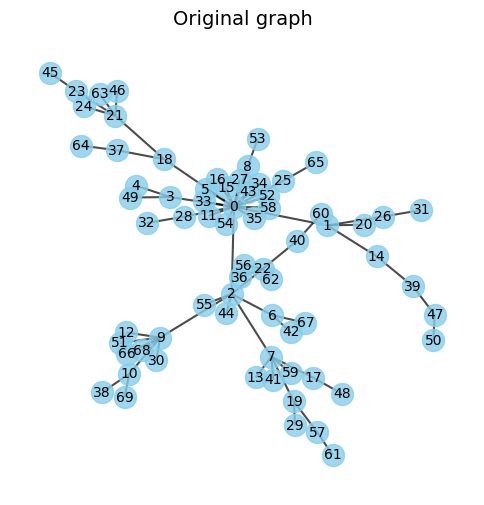

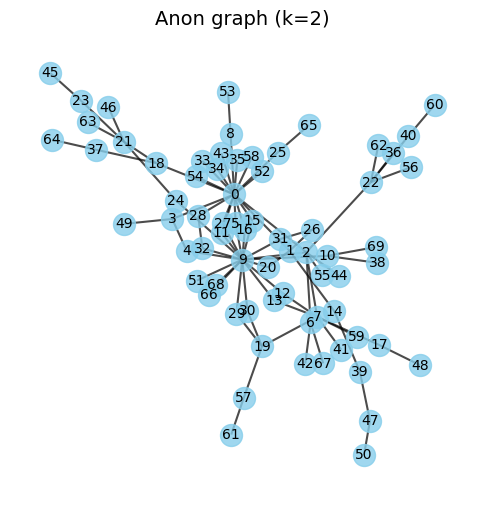

In [58]:
G_ba = nx.barabasi_albert_graph(n=70, m=1, seed=42)
plot_graph(G_ba, "Original graph")
G_anon, eq_classes_ba = social_anonymizer.anonymize_graph(G_ba, k=2, alpha=0, beta=1, gamma=1)
plot_graph(G_anon, "Anon graph (k=2)")

We then investigate the behavior for increasing values of k up to ∣V∣=70.

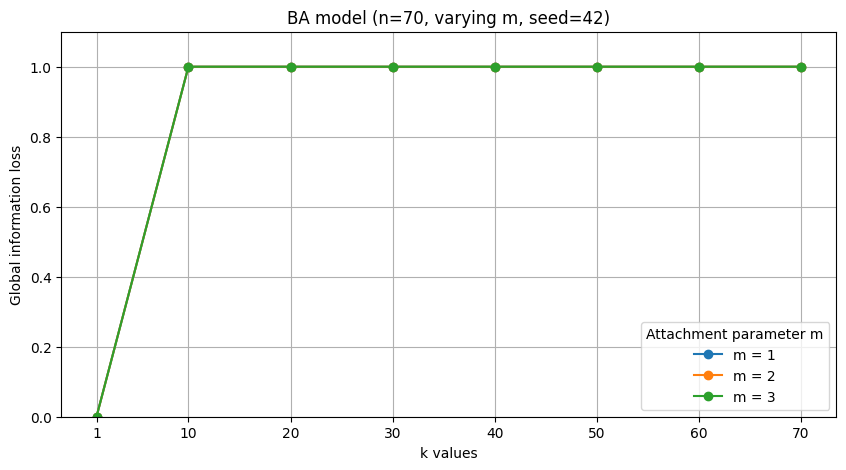

In [59]:
k_values = [1, 10, 20, 30, 40, 50, 60, 70]
m_values = [1, 2, 3]
n = 70
seed = 42

plt.figure(figsize=(10, 5))

for m in m_values:
    losses = []

    for k in k_values:
        try:
            G_ba = nx.barabasi_albert_graph(n=n, m=m, seed=seed)
            actual_edges = G_ba.number_of_edges()
            G_anon, eq_classes_ba = social_anonymizer.anonymize_graph(G_ba, k=k, alpha=0, beta=1, gamma=1)
            if len(check_isomorphic_classes(G_anon, eq_classes_ba)) != 0:
                raise Exception("Result is not isomorphic")
            
            losses.append(compute_global_loss(G_ba, G_anon))
        except Exception as e:
            print(f"BA skipped for seed {seed}: {e}")

    plt.plot(k_values, losses, marker='o', label=f"m = {m}")

plt.xlabel("k values")
plt.ylabel("Global information loss")
plt.ylim(0, 1.1)
plt.title(f"BA model (n={n}, varying m, seed={seed})")
plt.xticks(k_values)
plt.legend(title="Attachment parameter m")
plt.grid(True)
plt.show()

For all considered attachment parameter m, the global loss converges to 1.    
Moreover, given `k_values=[1, 10, 20, 30, 40, 50, 60, 70]`, for m={1, 2, 3}, there is not valid intermediate trade-off solution between privacy and utility in `k_values`. 

#### 4.4. Random graph topology vs Social network topology

To isolate the effect of network topology on the global loss as k increases, we fix both the number of nodes and the number of edges, and average the results over multiple random seeds. To ensure an identical edge count across models, we first generate Barabási–Albert (BA) graphs and record their number of edges. We then generate Erdős–Rényi graphs with the same number of nodes and edges using the G(N,M) model, rather than the G(N,p) formulation.

In [60]:
def loss_metric(G_orig, G_anon):
    return compute_global_loss(G_orig, G_anon)

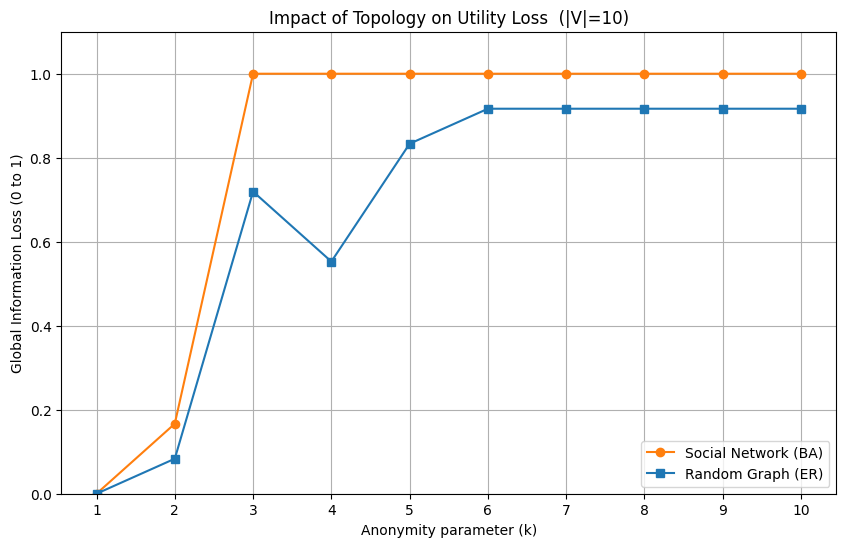

In [61]:
n = 10  
m = 1
k_values = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10] # Up to k=N 
seeds = [2, 4, 14, 16, 23, 24, 29, 30, 31, 36]
num_seeds = len(seeds)

ba_losses, er_losses = run_metric_comparison_experiment(
    n=n,
    m=m,
    k_values=k_values,
    seeds=seeds,
    num_seeds=num_seeds,
    experiment_func=loss_metric
)

plt.figure(figsize=(10, 6))
plt.plot(k_values, ba_losses, marker='o', color='tab:orange', label='Social Network (BA)')
plt.plot(k_values, er_losses, marker='s', color='tab:blue', label='Random Graph (ER)')
plt.xlabel("Anonymity parameter (k)")
plt.ylabel("Global Information Loss (0 to 1)")
plt.title(f"Impact of Topology on Utility Loss  (|V|={n})")
plt.ylim(0, 1.1)
plt.xticks(k_values)
plt.legend()
plt.grid(True)
plt.show()

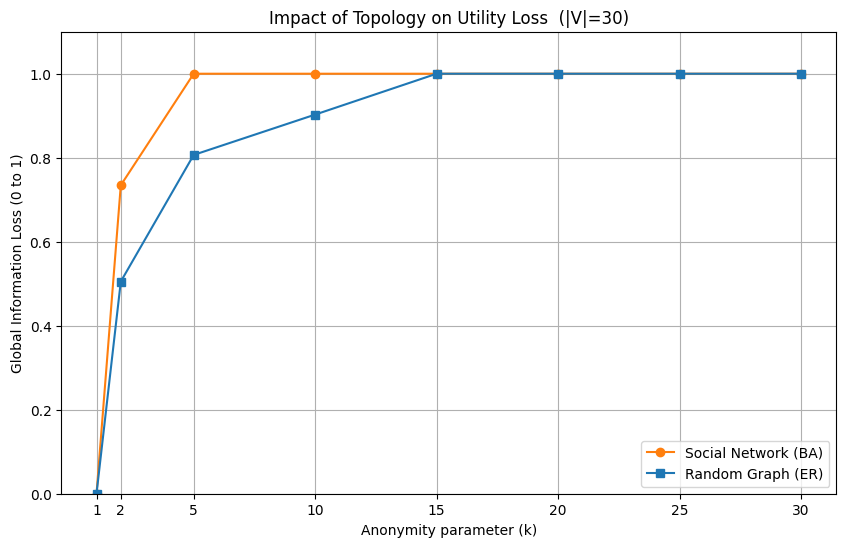

In [62]:
n = 30
m = 1
k_values = [1, 2, 5, 10, 15, 20, 25, 30] # Up to k=N
seeds = [2, 3, 4, 6, 8, 10, 13, 14, 16, 17]
num_seeds = len(seeds)

ba_losses, er_losses = run_metric_comparison_experiment(
    n=n,
    m=m,
    k_values=k_values,
    seeds=seeds,
    num_seeds=num_seeds,
    experiment_func=loss_metric
)

plt.figure(figsize=(10, 6))
plt.plot(k_values, ba_losses, marker='o', color='tab:orange', label='Social Network (BA)')
plt.plot(k_values, er_losses, marker='s', color='tab:blue', label='Random Graph (ER)')
plt.xlabel("Anonymity parameter (k)")
plt.ylabel("Global Information Loss (0 to 1)")
plt.title(f"Impact of Topology on Utility Loss  (|V|={n})")
plt.ylim(0, 1.1)
plt.xticks(k_values)
plt.legend()
plt.grid(True)
plt.show()

As expected, social network topologies exhibit a faster convergence of the global loss toward 1, suggesting that achieving higher levels of anonymity requires a rapid loss of structural information. This behavior implies that social networks offer fewer intermediate trade-off solutions between privacy protection and data utility.